## Домашнее задание №1

Драмбян Давид

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [ ]:
# ! pip install torch

In [ ]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt


### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [ ]:
x = torch.rand(6, 3) 
y = torch.rand(3, 4)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [ ]:
z = torch.empty(x.shape[0], y.shape[1])

torch.matmul(x, y, out=z)
print(z)

tensor([[0.6182, 2.1379, 1.1077, 1.4816],
        [0.5022, 1.5084, 0.5760, 1.1741],
        [0.4622, 1.4661, 0.5749, 1.0851],
        [0.4056, 1.3641, 0.7294, 0.9718],
        [0.2266, 0.9279, 0.7380, 0.5725],
        [0.4155, 1.3549, 0.5654, 0.9799]])


**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [ ]:
def relu_forward(x):
    x[x < 0] = 0
    return x

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def elu_forward(x):
    x_elu = torch.where(x<0, torch.exp(x), x)
    return x_elu


assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [ ]:
def lrelu_forward(x, alpha):
    x_lrelu = torch.where(x<0, alpha*x, x)
    return x_lrelu

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def mish(x):
    x_mish = x * torch.tanh(torch.log((1 + torch.exp(x))))
    return x_mish

In [ ]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [ ]:
def swish(x):
    x_swish = x * torch.sigmoid(x)
    return x_swish

In [ ]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

In [ ]:
# Хочется посмотреть, как выглядит swish

# t = (-1000 - 1000) * torch.rand(1, 10000) + 100
t = torch.arange(-20, 20, 0.01, dtype=torch.float32)

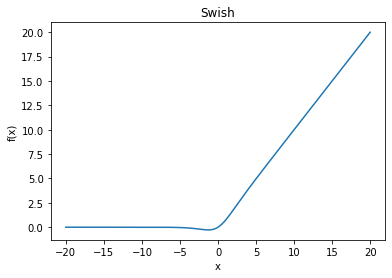

In [ ]:
plt.plot(t, swish(t))
plt.title('Swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [ ]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [ ]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)
        self.iteration = 1

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']

        
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            g = param.grad
            m = self._get_adam_buffer(param)[0]
            v = self._get_adam_buffer(param)[1]
            iteration = self._get_adam_buffer(param)[2]
            # print(g)
            
            # iteration += 1 
            # print(iteration)
            
            m *= beta_1 
            m.add_((1-beta_1)*g)
            v *= beta_2
            v.add_((1-beta_2)*(g**2))
            
            m_hat =  m / (1-(beta_1**self.iteration)) # m_hat
            v_hat = v / (1-(beta_2**self.iteration)) # v_hat
            # w_prev = param
            param.add_(m_hat/(torch.sqrt(v_hat+eps)), alpha=-lr)
            #if (param == w_prev).all(): 
             #   break
        self.iteration += 1

        
    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_m'], param_state['adam_v'], param_state['adam_iteration']

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_m' not in param_state:
            param_state['adam_m'] = torch.zeros_like(param)
            param_state['adam_v'] = torch.zeros_like(param)
            param_state['adam_iteration'] = torch.zeros(1)

Сравним оптимизатор с библиотечным

In [ ]:
from sklearn.datasets import make_regression


def seed_everything(seed):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)


def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

In [ ]:
def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())

In [ ]:
model = get_model()
optim = Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 4937.99267578125
Iteration 100 loss: 4844.25048828125
Iteration 200 loss: 4685.25732421875
Iteration 300 loss: 4437.0595703125
Iteration 400 loss: 4104.185546875
Iteration 500 loss: 3706.149658203125
Iteration 600 loss: 3271.7421875
Iteration 700 loss: 2826.925048828125
Iteration 800 loss: 2389.580810546875
Iteration 900 loss: 1970.45849609375


In [ ]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 4937.99267578125
Iteration 100 loss: 4844.25048828125
Iteration 200 loss: 4685.25732421875
Iteration 300 loss: 4437.0595703125
Iteration 400 loss: 4104.185546875
Iteration 500 loss: 3706.149658203125
Iteration 600 loss: 3271.7421875
Iteration 700 loss: 2826.925048828125
Iteration 800 loss: 2389.580810546875
Iteration 900 loss: 1970.45849609375


In [ ]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)>

 Наш оптимизационй алгоритм Adam работает идентично библиотечному с точностью до сотых. 

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [ ]:
nin = 784
nout = 10

weights = (-6**0.5/(nin+nout)**0.5 - 6**0.5/(nin+nout)**0.5) * torch.rand(nin, nout) + 6**0.5/(nin+nout)**0.5 # your code here
intercept = torch.ones(1, 10) # your code here

In [ ]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [ ]:
# ! pip install torchvision

In [ ]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [193]:
# Возьмем большие батчи для скорости обученияя, но этого будет достаточно для того, чтоы иллюстрировать метрики
batch_size_train = 1024 #128 1024
batch_size_test = 1024 #128 1024

In [183]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader( # your code here
                    fashion_mnist_train,
                    batch_size=batch_size_train, 
                    shuffle=True)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = test_loader = torch.utils.data.DataLoader( # your code here
                    fashion_mnist_eval,
                    batch_size=batch_size_test, 
                    shuffle=True)

Посмотрм, чтоо лежит в train_dataloader

In [184]:
for ii, (item, lbl) in enumerate(train_dataloader):
    if ii == 0:
        bbb = item
        ccc = lbl
        break

tensor(4)


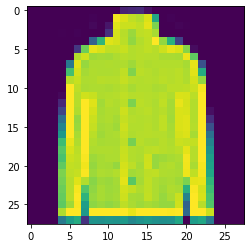

In [ ]:
n_item = 1

print(ccc[n_item])
plt.imshow(bbb[n_item][0])

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [ ]:
for i0, (images0, labels0) in enumerate(train_dataloader):
    image0 = images0.reshape(-1, 28*28)
    label0 = labels0

    print(i0)
    print(image0.shape)
    print(label0.shape)
    break

0
torch.Size([1024, 784])
torch.Size([1024])


In [185]:
loss_history = []
acc_history = []

In [186]:
def train_logistic_regression(weights, bias, batch, loss, optimizer, iteration):
    # for i, (images, labels) in enumerate(train_dataloader):
    (images, labels) = batch
    # Делаем предсказание
    image = images.view(-1, 28*28)
    # x_hat_lin = images.dot(weights.reshape(-1)) + bias
    weights.requires_grad = True
    bias.requires_grad = True
    x_hat_lin = image.matmul(weights) + bias
    # act = nn.LeakyReLU()
    # x_hat_act = act(x_hat_lin)
    smx = nn.Softmax(dim=1)
    x_hat = smx(x_hat_lin)

    # считаем лосс
    # one_hot = torch.zeros(128, 10)
    # for item in range(len(labels)):
      #   one_hot[item][labels[item]] = 1

    l = loss(x_hat, labels)

    l.backward()
    optimizer.step()

    optimizer.zero_grad()

    # метрики
    correct = 0
    total = 0
    for images, labels in test_loader:
        image = images.reshape(-1, 28*28)
        weights.requires_grad = True
        bias.requires_grad = True
        x_hat_lin = image.matmul(weights) + bias
        smx = nn.Softmax(dim=1)
        x_hat = smx(x_hat_lin)
        _, predicted = torch.max(x_hat.data, 1)
        
        total += len(labels)
        correct += (predicted == labels).sum()

    accuracy = 100 * int(correct)/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iteration, l.item(), accuracy))
    loss_history.append(l.item())
    acc_history.append(accuracy)

In [ ]:
iteration =0
for epoch in tqdm(range(1, 100)): # range(1, 100)
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, intercept, batch, criterion, optimizer, iteration)
        iteration += 1

  0%|          | 0/99 [00:00<?, ?it/s]

Iteration: 0. Loss: 2.3034019470214844. Accuracy: 20.14.
Iteration: 1. Loss: 2.286959648132324. Accuracy: 22.61.
Iteration: 2. Loss: 2.2750661373138428. Accuracy: 24.52.
Iteration: 3. Loss: 2.2658615112304688. Accuracy: 26.47.
Iteration: 4. Loss: 2.2523670196533203. Accuracy: 27.74.
Iteration: 5. Loss: 2.249741554260254. Accuracy: 28.8.
Iteration: 6. Loss: 2.2291629314422607. Accuracy: 29.48.
Iteration: 7. Loss: 2.218306064605713. Accuracy: 30.3.
Iteration: 8. Loss: 2.2161145210266113. Accuracy: 31.28.
Iteration: 9. Loss: 2.2042319774627686. Accuracy: 32.8.
Iteration: 10. Loss: 2.1971166133880615. Accuracy: 34.39.
Iteration: 11. Loss: 2.181398391723633. Accuracy: 36.61.
Iteration: 12. Loss: 2.1708121299743652. Accuracy: 38.52.
Iteration: 13. Loss: 2.151729106903076. Accuracy: 40.46.
Iteration: 14. Loss: 2.1341705322265625. Accuracy: 42.37.
Iteration: 15. Loss: 2.1465718746185303. Accuracy: 43.95.
Iteration: 16. Loss: 2.117403507232666. Accuracy: 45.43.
Iteration: 17. Loss: 2.1156086921

  1%|          | 1/99 [00:43<1:11:41, 43.89s/it]

Iteration: 58. Loss: 1.8565829992294312. Accuracy: 65.89.
Iteration: 59. Loss: 1.862070083618164. Accuracy: 66.09.
Iteration: 60. Loss: 1.8631620407104492. Accuracy: 66.21.
Iteration: 61. Loss: 1.8555991649627686. Accuracy: 66.35.
Iteration: 62. Loss: 1.8698790073394775. Accuracy: 66.5.
Iteration: 63. Loss: 1.8498687744140625. Accuracy: 66.54.
Iteration: 64. Loss: 1.8569468259811401. Accuracy: 66.79.
Iteration: 65. Loss: 1.849135160446167. Accuracy: 66.85.
Iteration: 66. Loss: 1.8522063493728638. Accuracy: 67.03.
Iteration: 67. Loss: 1.849359154701233. Accuracy: 67.26.
Iteration: 68. Loss: 1.827639102935791. Accuracy: 67.43.
Iteration: 69. Loss: 1.846707820892334. Accuracy: 67.62.
Iteration: 70. Loss: 1.842446208000183. Accuracy: 67.85.
Iteration: 71. Loss: 1.8337551355361938. Accuracy: 68.1.
Iteration: 72. Loss: 1.8382560014724731. Accuracy: 68.39.
Iteration: 73. Loss: 1.8653206825256348. Accuracy: 68.76.
Iteration: 74. Loss: 1.8189966678619385. Accuracy: 68.94.
Iteration: 75. Loss: 1

  2%|▏         | 2/99 [01:27<1:10:56, 43.88s/it]

Iteration: 117. Loss: 1.8015847206115723. Accuracy: 72.65.
Iteration: 118. Loss: 1.7736809253692627. Accuracy: 72.8.
Iteration: 119. Loss: 1.7693812847137451. Accuracy: 72.86.
Iteration: 120. Loss: 1.7791775465011597. Accuracy: 73.01.
Iteration: 121. Loss: 1.7705373764038086. Accuracy: 73.09.
Iteration: 122. Loss: 1.7724285125732422. Accuracy: 73.12.
Iteration: 123. Loss: 1.7956669330596924. Accuracy: 73.21.
Iteration: 124. Loss: 1.7820347547531128. Accuracy: 73.22.
Iteration: 125. Loss: 1.780425786972046. Accuracy: 73.23.
Iteration: 126. Loss: 1.7610011100769043. Accuracy: 73.25.
Iteration: 127. Loss: 1.765258550643921. Accuracy: 73.37.
Iteration: 128. Loss: 1.7828421592712402. Accuracy: 73.38.
Iteration: 129. Loss: 1.7647336721420288. Accuracy: 73.39.
Iteration: 130. Loss: 1.7791012525558472. Accuracy: 73.38.
Iteration: 131. Loss: 1.7680655717849731. Accuracy: 73.4.
Iteration: 132. Loss: 1.7822139263153076. Accuracy: 73.39.
Iteration: 133. Loss: 1.7559667825698853. Accuracy: 73.44.
I

  3%|▎         | 3/99 [02:14<1:11:48, 44.88s/it]

Iteration: 176. Loss: 1.7363700866699219. Accuracy: 74.96.
Iteration: 177. Loss: 1.7410237789154053. Accuracy: 75.02.
Iteration: 178. Loss: 1.7497389316558838. Accuracy: 75.1.
Iteration: 179. Loss: 1.7411127090454102. Accuracy: 75.02.
Iteration: 180. Loss: 1.744162917137146. Accuracy: 75.08.
Iteration: 181. Loss: 1.7449311017990112. Accuracy: 75.0.
Iteration: 182. Loss: 1.7520469427108765. Accuracy: 74.96.
Iteration: 183. Loss: 1.748967170715332. Accuracy: 75.08.
Iteration: 184. Loss: 1.7633002996444702. Accuracy: 75.02.
Iteration: 185. Loss: 1.748419165611267. Accuracy: 75.09.
Iteration: 186. Loss: 1.7590619325637817. Accuracy: 75.17.
Iteration: 187. Loss: 1.7439788579940796. Accuracy: 75.24.
Iteration: 188. Loss: 1.7505415678024292. Accuracy: 75.1.
Iteration: 189. Loss: 1.7448586225509644. Accuracy: 75.1.
Iteration: 190. Loss: 1.7541478872299194. Accuracy: 74.99.
Iteration: 191. Loss: 1.760015845298767. Accuracy: 75.0.
Iteration: 192. Loss: 1.7420759201049805. Accuracy: 75.0.
Iterati

  4%|▍         | 4/99 [02:58<1:10:38, 44.61s/it]

Iteration: 235. Loss: 1.7258977890014648. Accuracy: 76.19.
Iteration: 236. Loss: 1.7294732332229614. Accuracy: 76.26.
Iteration: 237. Loss: 1.7207505702972412. Accuracy: 76.26.
Iteration: 238. Loss: 1.7152067422866821. Accuracy: 76.27.
Iteration: 239. Loss: 1.7282246351242065. Accuracy: 76.27.
Iteration: 240. Loss: 1.7382054328918457. Accuracy: 76.34.
Iteration: 241. Loss: 1.7379324436187744. Accuracy: 76.34.
Iteration: 242. Loss: 1.7317062616348267. Accuracy: 76.28.
Iteration: 243. Loss: 1.7160900831222534. Accuracy: 76.29.
Iteration: 244. Loss: 1.7086025476455688. Accuracy: 76.15.
Iteration: 245. Loss: 1.7392337322235107. Accuracy: 76.09.
Iteration: 246. Loss: 1.730534553527832. Accuracy: 76.1.
Iteration: 247. Loss: 1.7419849634170532. Accuracy: 76.15.
Iteration: 248. Loss: 1.750541090965271. Accuracy: 76.18.
Iteration: 249. Loss: 1.7219749689102173. Accuracy: 76.21.
Iteration: 250. Loss: 1.7459328174591064. Accuracy: 76.34.
Iteration: 251. Loss: 1.732251763343811. Accuracy: 76.42.
I

  5%|▌         | 5/99 [03:42<1:09:35, 44.42s/it]

Iteration: 294. Loss: 1.6913564205169678. Accuracy: 79.16.
Iteration: 295. Loss: 1.6975691318511963. Accuracy: 79.14.
Iteration: 296. Loss: 1.7240334749221802. Accuracy: 79.04.
Iteration: 297. Loss: 1.7095791101455688. Accuracy: 79.22.
Iteration: 298. Loss: 1.709517002105713. Accuracy: 79.32.
Iteration: 299. Loss: 1.699390172958374. Accuracy: 79.32.
Iteration: 300. Loss: 1.7048527002334595. Accuracy: 79.38.
Iteration: 301. Loss: 1.7051982879638672. Accuracy: 79.41.
Iteration: 302. Loss: 1.7085106372833252. Accuracy: 79.46.
Iteration: 303. Loss: 1.715694546699524. Accuracy: 79.48.
Iteration: 304. Loss: 1.694693922996521. Accuracy: 79.54.
Iteration: 305. Loss: 1.7070084810256958. Accuracy: 79.58.
Iteration: 306. Loss: 1.7009121179580688. Accuracy: 79.56.
Iteration: 307. Loss: 1.7028416395187378. Accuracy: 79.62.
Iteration: 308. Loss: 1.710503339767456. Accuracy: 79.67.
Iteration: 309. Loss: 1.712093710899353. Accuracy: 79.63.
Iteration: 310. Loss: 1.7125282287597656. Accuracy: 79.77.
Ite

  6%|▌         | 6/99 [04:26<1:08:39, 44.29s/it]

Iteration: 353. Loss: 1.6986297369003296. Accuracy: 80.14.
Iteration: 354. Loss: 1.6931369304656982. Accuracy: 80.12.
Iteration: 355. Loss: 1.6904629468917847. Accuracy: 80.11.
Iteration: 356. Loss: 1.6907110214233398. Accuracy: 80.13.
Iteration: 357. Loss: 1.6859210729599. Accuracy: 79.99.
Iteration: 358. Loss: 1.6712450981140137. Accuracy: 80.02.
Iteration: 359. Loss: 1.6951665878295898. Accuracy: 80.11.
Iteration: 360. Loss: 1.6897915601730347. Accuracy: 80.14.
Iteration: 361. Loss: 1.6905516386032104. Accuracy: 80.24.
Iteration: 362. Loss: 1.6925060749053955. Accuracy: 80.29.
Iteration: 363. Loss: 1.6799081563949585. Accuracy: 80.17.
Iteration: 364. Loss: 1.6825599670410156. Accuracy: 80.15.
Iteration: 365. Loss: 1.7102456092834473. Accuracy: 80.1.
Iteration: 366. Loss: 1.693578839302063. Accuracy: 80.08.
Iteration: 367. Loss: 1.687638759613037. Accuracy: 80.04.
Iteration: 368. Loss: 1.693053960800171. Accuracy: 80.06.
Iteration: 369. Loss: 1.6961816549301147. Accuracy: 80.01.
Iter

  7%|▋         | 7/99 [05:11<1:07:50, 44.24s/it]

Iteration: 412. Loss: 1.6747413873672485. Accuracy: 80.45.
Iteration: 413. Loss: 1.6733191013336182. Accuracy: 80.47.
Iteration: 414. Loss: 1.6854897737503052. Accuracy: 80.48.
Iteration: 415. Loss: 1.666715383529663. Accuracy: 80.51.
Iteration: 416. Loss: 1.681622862815857. Accuracy: 80.5.
Iteration: 417. Loss: 1.6737520694732666. Accuracy: 80.6.
Iteration: 418. Loss: 1.6951322555541992. Accuracy: 80.56.
Iteration: 419. Loss: 1.6969928741455078. Accuracy: 80.58.
Iteration: 420. Loss: 1.6695518493652344. Accuracy: 80.55.
Iteration: 421. Loss: 1.6870368719100952. Accuracy: 80.57.
Iteration: 422. Loss: 1.6886589527130127. Accuracy: 80.65.
Iteration: 423. Loss: 1.6870176792144775. Accuracy: 80.64.
Iteration: 424. Loss: 1.6846133470535278. Accuracy: 80.66.
Iteration: 425. Loss: 1.705200433731079. Accuracy: 80.62.
Iteration: 426. Loss: 1.685329556465149. Accuracy: 80.68.
Iteration: 427. Loss: 1.6817970275878906. Accuracy: 80.73.
Iteration: 428. Loss: 1.6869851350784302. Accuracy: 80.64.
Ite

  8%|▊         | 8/99 [05:55<1:06:59, 44.17s/it]

Iteration: 471. Loss: 1.653894066810608. Accuracy: 80.76.
Iteration: 472. Loss: 1.6719385385513306. Accuracy: 80.82.
Iteration: 473. Loss: 1.6838070154190063. Accuracy: 80.95.
Iteration: 474. Loss: 1.6931754350662231. Accuracy: 81.04.
Iteration: 475. Loss: 1.6563280820846558. Accuracy: 81.12.
Iteration: 476. Loss: 1.679795742034912. Accuracy: 81.2.
Iteration: 477. Loss: 1.6552116870880127. Accuracy: 81.2.
Iteration: 478. Loss: 1.6834293603897095. Accuracy: 81.1.
Iteration: 479. Loss: 1.67368745803833. Accuracy: 81.07.
Iteration: 480. Loss: 1.6590296030044556. Accuracy: 81.11.
Iteration: 481. Loss: 1.666983723640442. Accuracy: 81.08.
Iteration: 482. Loss: 1.675065279006958. Accuracy: 81.12.
Iteration: 483. Loss: 1.6803158521652222. Accuracy: 81.16.
Iteration: 484. Loss: 1.6755151748657227. Accuracy: 81.17.
Iteration: 485. Loss: 1.6657546758651733. Accuracy: 81.17.
Iteration: 486. Loss: 1.6474697589874268. Accuracy: 81.19.
Iteration: 487. Loss: 1.665036678314209. Accuracy: 81.15.
Iterati

  9%|▉         | 9/99 [06:39<1:06:13, 44.15s/it]

Iteration: 530. Loss: 1.668492317199707. Accuracy: 81.35.
Iteration: 531. Loss: 1.668277621269226. Accuracy: 81.39.
Iteration: 532. Loss: 1.6787997484207153. Accuracy: 81.37.
Iteration: 533. Loss: 1.6664471626281738. Accuracy: 81.39.
Iteration: 534. Loss: 1.6675077676773071. Accuracy: 81.42.
Iteration: 535. Loss: 1.6883348226547241. Accuracy: 81.51.
Iteration: 536. Loss: 1.656139612197876. Accuracy: 81.48.
Iteration: 537. Loss: 1.6726127862930298. Accuracy: 81.46.
Iteration: 538. Loss: 1.6731809377670288. Accuracy: 81.43.
Iteration: 539. Loss: 1.6694072484970093. Accuracy: 81.45.
Iteration: 540. Loss: 1.6603151559829712. Accuracy: 81.46.
Iteration: 541. Loss: 1.668662428855896. Accuracy: 81.5.
Iteration: 542. Loss: 1.6704646348953247. Accuracy: 81.55.
Iteration: 543. Loss: 1.6538007259368896. Accuracy: 81.46.
Iteration: 544. Loss: 1.6718900203704834. Accuracy: 81.41.
Iteration: 545. Loss: 1.665711760520935. Accuracy: 81.38.
Iteration: 546. Loss: 1.6839197874069214. Accuracy: 81.43.
Ite

 10%|█         | 10/99 [07:23<1:05:31, 44.18s/it]

Iteration: 589. Loss: 1.6704059839248657. Accuracy: 81.6.
Iteration: 590. Loss: 1.6693273782730103. Accuracy: 81.62.
Iteration: 591. Loss: 1.6679874658584595. Accuracy: 81.67.
Iteration: 592. Loss: 1.6554853916168213. Accuracy: 81.67.
Iteration: 593. Loss: 1.6629093885421753. Accuracy: 81.71.
Iteration: 594. Loss: 1.6551786661148071. Accuracy: 81.66.
Iteration: 595. Loss: 1.6733113527297974. Accuracy: 81.61.
Iteration: 596. Loss: 1.6404082775115967. Accuracy: 81.55.
Iteration: 597. Loss: 1.6568760871887207. Accuracy: 81.61.
Iteration: 598. Loss: 1.6633926630020142. Accuracy: 81.65.
Iteration: 599. Loss: 1.6554073095321655. Accuracy: 81.6.
Iteration: 600. Loss: 1.6505199670791626. Accuracy: 81.64.
Iteration: 601. Loss: 1.6706486940383911. Accuracy: 81.7.
Iteration: 602. Loss: 1.659977674484253. Accuracy: 81.75.
Iteration: 603. Loss: 1.6535967588424683. Accuracy: 81.68.
Iteration: 604. Loss: 1.674023151397705. Accuracy: 81.68.
Iteration: 605. Loss: 1.6644186973571777. Accuracy: 81.68.
It

 11%|█         | 11/99 [08:07<1:04:45, 44.15s/it]

Iteration: 648. Loss: 1.665313959121704. Accuracy: 81.99.
Iteration: 649. Loss: 1.6718543767929077. Accuracy: 81.9.
Iteration: 650. Loss: 1.6659165620803833. Accuracy: 81.93.
Iteration: 651. Loss: 1.6611034870147705. Accuracy: 81.9.
Iteration: 652. Loss: 1.6435275077819824. Accuracy: 81.89.
Iteration: 653. Loss: 1.6708747148513794. Accuracy: 81.91.
Iteration: 654. Loss: 1.6780539751052856. Accuracy: 81.96.
Iteration: 655. Loss: 1.670608639717102. Accuracy: 81.94.
Iteration: 656. Loss: 1.6544315814971924. Accuracy: 81.87.
Iteration: 657. Loss: 1.6593592166900635. Accuracy: 81.88.
Iteration: 658. Loss: 1.664366364479065. Accuracy: 81.92.
Iteration: 659. Loss: 1.6588973999023438. Accuracy: 81.84.
Iteration: 660. Loss: 1.6614450216293335. Accuracy: 81.83.
Iteration: 661. Loss: 1.6630269289016724. Accuracy: 81.83.
Iteration: 662. Loss: 1.6779117584228516. Accuracy: 81.86.
Iteration: 663. Loss: 1.6691701412200928. Accuracy: 81.89.
Iteration: 664. Loss: 1.6483012437820435. Accuracy: 81.92.
It

 12%|█▏        | 12/99 [08:51<1:04:00, 44.15s/it]

Iteration: 707. Loss: 1.652228832244873. Accuracy: 82.22.
Iteration: 708. Loss: 1.6731531620025635. Accuracy: 82.23.
Iteration: 709. Loss: 1.6616628170013428. Accuracy: 82.21.
Iteration: 710. Loss: 1.6643626689910889. Accuracy: 82.18.
Iteration: 711. Loss: 1.6526378393173218. Accuracy: 82.18.
Iteration: 712. Loss: 1.6658413410186768. Accuracy: 82.09.
Iteration: 713. Loss: 1.6468522548675537. Accuracy: 82.14.
Iteration: 714. Loss: 1.6555492877960205. Accuracy: 82.22.
Iteration: 715. Loss: 1.650839924812317. Accuracy: 82.22.
Iteration: 716. Loss: 1.6505008935928345. Accuracy: 82.26.
Iteration: 717. Loss: 1.6574543714523315. Accuracy: 82.24.
Iteration: 718. Loss: 1.6424795389175415. Accuracy: 82.26.
Iteration: 719. Loss: 1.6516262292861938. Accuracy: 82.19.
Iteration: 720. Loss: 1.6563453674316406. Accuracy: 82.15.
Iteration: 721. Loss: 1.6604602336883545. Accuracy: 82.16.
Iteration: 722. Loss: 1.651721715927124. Accuracy: 82.12.
Iteration: 723. Loss: 1.6321569681167603. Accuracy: 82.13.


 13%|█▎        | 13/99 [09:35<1:03:13, 44.11s/it]

Iteration: 766. Loss: 1.658721685409546. Accuracy: 82.36.
Iteration: 767. Loss: 1.6454812288284302. Accuracy: 82.35.
Iteration: 768. Loss: 1.6473357677459717. Accuracy: 82.43.
Iteration: 769. Loss: 1.661362886428833. Accuracy: 82.48.
Iteration: 770. Loss: 1.6674509048461914. Accuracy: 82.38.
Iteration: 771. Loss: 1.6697163581848145. Accuracy: 82.33.
Iteration: 772. Loss: 1.6655032634735107. Accuracy: 82.34.
Iteration: 773. Loss: 1.6432925462722778. Accuracy: 82.25.
Iteration: 774. Loss: 1.6549361944198608. Accuracy: 82.29.
Iteration: 775. Loss: 1.6536897420883179. Accuracy: 82.35.
Iteration: 776. Loss: 1.6540641784667969. Accuracy: 82.35.
Iteration: 777. Loss: 1.6337664127349854. Accuracy: 82.39.
Iteration: 778. Loss: 1.6496293544769287. Accuracy: 82.37.
Iteration: 779. Loss: 1.6553480625152588. Accuracy: 82.36.
Iteration: 780. Loss: 1.665454387664795. Accuracy: 82.33.
Iteration: 781. Loss: 1.6436728239059448. Accuracy: 82.36.
Iteration: 782. Loss: 1.6334420442581177. Accuracy: 82.33.


 14%|█▍        | 14/99 [10:19<1:02:27, 44.09s/it]

Iteration: 825. Loss: 1.6555159091949463. Accuracy: 82.56.
Iteration: 826. Loss: 1.6551692485809326. Accuracy: 82.54.
Iteration: 827. Loss: 1.64405357837677. Accuracy: 82.52.
Iteration: 828. Loss: 1.6572428941726685. Accuracy: 82.58.
Iteration: 829. Loss: 1.6503770351409912. Accuracy: 82.54.
Iteration: 830. Loss: 1.6517016887664795. Accuracy: 82.54.
Iteration: 831. Loss: 1.6684292554855347. Accuracy: 82.58.
Iteration: 832. Loss: 1.6623705625534058. Accuracy: 82.53.
Iteration: 833. Loss: 1.648876428604126. Accuracy: 82.5.
Iteration: 834. Loss: 1.646789789199829. Accuracy: 82.45.
Iteration: 835. Loss: 1.6380205154418945. Accuracy: 82.4.
Iteration: 836. Loss: 1.670503854751587. Accuracy: 82.34.
Iteration: 837. Loss: 1.65855872631073. Accuracy: 82.4.
Iteration: 838. Loss: 1.647409439086914. Accuracy: 82.43.
Iteration: 839. Loss: 1.6575878858566284. Accuracy: 82.43.
Iteration: 840. Loss: 1.6368639469146729. Accuracy: 82.41.
Iteration: 841. Loss: 1.6321791410446167. Accuracy: 82.43.
Iteratio

 15%|█▌        | 15/99 [11:03<1:01:44, 44.10s/it]

Iteration: 884. Loss: 1.6520931720733643. Accuracy: 82.67.
Iteration: 885. Loss: 1.6347063779830933. Accuracy: 82.68.
Iteration: 886. Loss: 1.643489122390747. Accuracy: 82.73.
Iteration: 887. Loss: 1.6363296508789062. Accuracy: 82.7.
Iteration: 888. Loss: 1.652010440826416. Accuracy: 82.72.
Iteration: 889. Loss: 1.6359727382659912. Accuracy: 82.71.
Iteration: 890. Loss: 1.6391481161117554. Accuracy: 82.67.
Iteration: 891. Loss: 1.6576268672943115. Accuracy: 82.64.
Iteration: 892. Loss: 1.6558539867401123. Accuracy: 82.66.
Iteration: 893. Loss: 1.6674134731292725. Accuracy: 82.63.
Iteration: 894. Loss: 1.6581565141677856. Accuracy: 82.64.
Iteration: 895. Loss: 1.6488713026046753. Accuracy: 82.68.
Iteration: 896. Loss: 1.6246615648269653. Accuracy: 82.69.
Iteration: 897. Loss: 1.6609071493148804. Accuracy: 82.75.
Iteration: 898. Loss: 1.6253799200057983. Accuracy: 82.71.
Iteration: 899. Loss: 1.6387439966201782. Accuracy: 82.73.
Iteration: 900. Loss: 1.6478586196899414. Accuracy: 82.76.


 16%|█▌        | 16/99 [11:50<1:02:11, 44.95s/it]

Iteration: 943. Loss: 1.6482375860214233. Accuracy: 82.75.
Iteration: 944. Loss: 1.6491992473602295. Accuracy: 82.75.
Iteration: 945. Loss: 1.6539256572723389. Accuracy: 82.73.
Iteration: 946. Loss: 1.636746883392334. Accuracy: 82.73.
Iteration: 947. Loss: 1.6426043510437012. Accuracy: 82.67.
Iteration: 948. Loss: 1.6451666355133057. Accuracy: 82.7.
Iteration: 949. Loss: 1.637858510017395. Accuracy: 82.72.
Iteration: 950. Loss: 1.6648809909820557. Accuracy: 82.72.
Iteration: 951. Loss: 1.6421496868133545. Accuracy: 82.61.
Iteration: 952. Loss: 1.6516287326812744. Accuracy: 82.68.
Iteration: 953. Loss: 1.6458771228790283. Accuracy: 82.65.
Iteration: 954. Loss: 1.6516255140304565. Accuracy: 82.58.
Iteration: 955. Loss: 1.6343549489974976. Accuracy: 82.54.
Iteration: 956. Loss: 1.6299324035644531. Accuracy: 82.46.
Iteration: 957. Loss: 1.6293450593948364. Accuracy: 82.48.
Iteration: 958. Loss: 1.6460479497909546. Accuracy: 82.55.
Iteration: 959. Loss: 1.6452207565307617. Accuracy: 82.59.


 17%|█▋        | 17/99 [12:35<1:01:09, 44.76s/it]

Iteration: 1002. Loss: 1.6454801559448242. Accuracy: 82.84.
Iteration: 1003. Loss: 1.6309605836868286. Accuracy: 82.85.
Iteration: 1004. Loss: 1.657039999961853. Accuracy: 82.92.
Iteration: 1005. Loss: 1.6227105855941772. Accuracy: 82.9.
Iteration: 1006. Loss: 1.6629753112792969. Accuracy: 82.91.
Iteration: 1007. Loss: 1.6446380615234375. Accuracy: 82.93.
Iteration: 1008. Loss: 1.6305571794509888. Accuracy: 82.96.
Iteration: 1009. Loss: 1.6330199241638184. Accuracy: 82.91.
Iteration: 1010. Loss: 1.6456108093261719. Accuracy: 82.89.
Iteration: 1011. Loss: 1.6278162002563477. Accuracy: 82.91.
Iteration: 1012. Loss: 1.6469800472259521. Accuracy: 82.92.
Iteration: 1013. Loss: 1.6451783180236816. Accuracy: 82.94.
Iteration: 1014. Loss: 1.6650422811508179. Accuracy: 82.92.
Iteration: 1015. Loss: 1.6569228172302246. Accuracy: 82.94.
Iteration: 1016. Loss: 1.6392185688018799. Accuracy: 82.99.
Iteration: 1017. Loss: 1.6486389636993408. Accuracy: 82.92.
Iteration: 1018. Loss: 1.630340576171875. 

 18%|█▊        | 18/99 [13:19<1:00:10, 44.57s/it]

Iteration: 1061. Loss: 1.6489845514297485. Accuracy: 83.05.
Iteration: 1062. Loss: 1.642149567604065. Accuracy: 83.06.
Iteration: 1063. Loss: 1.6559895277023315. Accuracy: 83.01.
Iteration: 1064. Loss: 1.6379590034484863. Accuracy: 83.0.
Iteration: 1065. Loss: 1.6241618394851685. Accuracy: 82.92.
Iteration: 1066. Loss: 1.6397923231124878. Accuracy: 82.9.
Iteration: 1067. Loss: 1.6410168409347534. Accuracy: 82.82.
Iteration: 1068. Loss: 1.6445977687835693. Accuracy: 82.8.
Iteration: 1069. Loss: 1.6312206983566284. Accuracy: 82.77.
Iteration: 1070. Loss: 1.649348258972168. Accuracy: 82.79.
Iteration: 1071. Loss: 1.6444368362426758. Accuracy: 82.8.
Iteration: 1072. Loss: 1.6246236562728882. Accuracy: 82.81.
Iteration: 1073. Loss: 1.66526198387146. Accuracy: 82.9.
Iteration: 1074. Loss: 1.653752088546753. Accuracy: 82.93.
Iteration: 1075. Loss: 1.6333104372024536. Accuracy: 82.98.
Iteration: 1076. Loss: 1.645410418510437. Accuracy: 82.97.
Iteration: 1077. Loss: 1.6348408460617065. Accuracy

 19%|█▉        | 19/99 [14:03<59:29, 44.62s/it]  

Iteration: 1120. Loss: 1.653193473815918. Accuracy: 83.06.
Iteration: 1121. Loss: 1.634279727935791. Accuracy: 83.05.
Iteration: 1122. Loss: 1.6469953060150146. Accuracy: 83.05.
Iteration: 1123. Loss: 1.6278870105743408. Accuracy: 83.06.
Iteration: 1124. Loss: 1.6474261283874512. Accuracy: 83.11.
Iteration: 1125. Loss: 1.6435295343399048. Accuracy: 83.12.
Iteration: 1126. Loss: 1.6292660236358643. Accuracy: 83.16.
Iteration: 1127. Loss: 1.628240942955017. Accuracy: 83.2.
Iteration: 1128. Loss: 1.6344155073165894. Accuracy: 83.23.
Iteration: 1129. Loss: 1.6589488983154297. Accuracy: 83.19.
Iteration: 1130. Loss: 1.6494896411895752. Accuracy: 83.2.
Iteration: 1131. Loss: 1.6502162218093872. Accuracy: 83.22.
Iteration: 1132. Loss: 1.6201205253601074. Accuracy: 83.2.
Iteration: 1133. Loss: 1.6533873081207275. Accuracy: 83.13.
Iteration: 1134. Loss: 1.6539301872253418. Accuracy: 83.17.
Iteration: 1135. Loss: 1.6603585481643677. Accuracy: 83.13.
Iteration: 1136. Loss: 1.636643409729004. Accu

 20%|██        | 20/99 [14:47<58:32, 44.46s/it]

Iteration: 1179. Loss: 1.6361644268035889. Accuracy: 83.08.
Iteration: 1180. Loss: 1.6438860893249512. Accuracy: 83.09.
Iteration: 1181. Loss: 1.639127254486084. Accuracy: 83.14.
Iteration: 1182. Loss: 1.6241810321807861. Accuracy: 83.15.
Iteration: 1183. Loss: 1.6249029636383057. Accuracy: 83.15.
Iteration: 1184. Loss: 1.655025839805603. Accuracy: 83.17.
Iteration: 1185. Loss: 1.6424155235290527. Accuracy: 83.17.
Iteration: 1186. Loss: 1.6332275867462158. Accuracy: 83.13.
Iteration: 1187. Loss: 1.6367474794387817. Accuracy: 83.1.
Iteration: 1188. Loss: 1.651546597480774. Accuracy: 83.1.
Iteration: 1189. Loss: 1.6439965963363647. Accuracy: 83.19.
Iteration: 1190. Loss: 1.6537699699401855. Accuracy: 83.19.
Iteration: 1191. Loss: 1.639135718345642. Accuracy: 83.19.
Iteration: 1192. Loss: 1.6505342721939087. Accuracy: 83.14.
Iteration: 1193. Loss: 1.6418005228042603. Accuracy: 83.07.
Iteration: 1194. Loss: 1.6540141105651855. Accuracy: 83.16.
Iteration: 1195. Loss: 1.6450656652450562. Acc

 21%|██        | 21/99 [15:32<57:40, 44.37s/it]

Iteration: 1238. Loss: 1.6311047077178955. Accuracy: 83.19.
Iteration: 1239. Loss: 1.6325525045394897. Accuracy: 83.2.
Iteration: 1240. Loss: 1.6355431079864502. Accuracy: 83.19.
Iteration: 1241. Loss: 1.6487425565719604. Accuracy: 83.27.
Iteration: 1242. Loss: 1.6394693851470947. Accuracy: 83.28.
Iteration: 1243. Loss: 1.6262353658676147. Accuracy: 83.28.
Iteration: 1244. Loss: 1.632163643836975. Accuracy: 83.26.
Iteration: 1245. Loss: 1.6469099521636963. Accuracy: 83.29.
Iteration: 1246. Loss: 1.642983317375183. Accuracy: 83.25.
Iteration: 1247. Loss: 1.6495879888534546. Accuracy: 83.16.
Iteration: 1248. Loss: 1.6377021074295044. Accuracy: 83.14.
Iteration: 1249. Loss: 1.6201739311218262. Accuracy: 83.13.
Iteration: 1250. Loss: 1.6371227502822876. Accuracy: 83.11.
Iteration: 1251. Loss: 1.6346917152404785. Accuracy: 83.05.
Iteration: 1252. Loss: 1.6311854124069214. Accuracy: 83.1.
Iteration: 1253. Loss: 1.657859444618225. Accuracy: 83.15.
Iteration: 1254. Loss: 1.6284867525100708. Ac

 22%|██▏       | 22/99 [16:16<56:49, 44.28s/it]

Iteration: 1297. Loss: 1.6377019882202148. Accuracy: 83.3.
Iteration: 1298. Loss: 1.642094612121582. Accuracy: 83.25.
Iteration: 1299. Loss: 1.6321555376052856. Accuracy: 83.09.
Iteration: 1300. Loss: 1.637728214263916. Accuracy: 83.09.
Iteration: 1301. Loss: 1.6347507238388062. Accuracy: 83.1.
Iteration: 1302. Loss: 1.6306383609771729. Accuracy: 83.16.
Iteration: 1303. Loss: 1.6441904306411743. Accuracy: 83.12.
Iteration: 1304. Loss: 1.6303669214248657. Accuracy: 83.15.
Iteration: 1305. Loss: 1.6372724771499634. Accuracy: 83.24.
Iteration: 1306. Loss: 1.6334881782531738. Accuracy: 83.29.
Iteration: 1307. Loss: 1.6386001110076904. Accuracy: 83.31.
Iteration: 1308. Loss: 1.6520862579345703. Accuracy: 83.3.
Iteration: 1309. Loss: 1.653042197227478. Accuracy: 83.33.
Iteration: 1310. Loss: 1.630672574043274. Accuracy: 83.38.
Iteration: 1311. Loss: 1.6218291521072388. Accuracy: 83.34.
Iteration: 1312. Loss: 1.6370035409927368. Accuracy: 83.31.
Iteration: 1313. Loss: 1.6274317502975464. Accu

 23%|██▎       | 23/99 [17:00<56:01, 44.23s/it]

Iteration: 1356. Loss: 1.6179805994033813. Accuracy: 83.41.
Iteration: 1357. Loss: 1.6427686214447021. Accuracy: 83.45.
Iteration: 1358. Loss: 1.6387370824813843. Accuracy: 83.38.
Iteration: 1359. Loss: 1.623761773109436. Accuracy: 83.44.
Iteration: 1360. Loss: 1.6292439699172974. Accuracy: 83.46.
Iteration: 1361. Loss: 1.6178768873214722. Accuracy: 83.48.
Iteration: 1362. Loss: 1.6311579942703247. Accuracy: 83.44.
Iteration: 1363. Loss: 1.6423029899597168. Accuracy: 83.38.
Iteration: 1364. Loss: 1.639968991279602. Accuracy: 83.39.
Iteration: 1365. Loss: 1.6186087131500244. Accuracy: 83.39.
Iteration: 1366. Loss: 1.623017430305481. Accuracy: 83.44.
Iteration: 1367. Loss: 1.61379873752594. Accuracy: 83.44.
Iteration: 1368. Loss: 1.6347997188568115. Accuracy: 83.37.
Iteration: 1369. Loss: 1.6305238008499146. Accuracy: 83.37.
Iteration: 1370. Loss: 1.635571837425232. Accuracy: 83.46.
Iteration: 1371. Loss: 1.644452452659607. Accuracy: 83.46.
Iteration: 1372. Loss: 1.6407408714294434. Accu

 24%|██▍       | 24/99 [17:44<55:17, 44.23s/it]

Iteration: 1415. Loss: 1.6261307001113892. Accuracy: 83.3.
Iteration: 1416. Loss: 1.6395658254623413. Accuracy: 83.36.
Iteration: 1417. Loss: 1.6437586545944214. Accuracy: 83.22.
Iteration: 1418. Loss: 1.6338316202163696. Accuracy: 83.24.
Iteration: 1419. Loss: 1.6415671110153198. Accuracy: 83.25.
Iteration: 1420. Loss: 1.637700080871582. Accuracy: 83.21.
Iteration: 1421. Loss: 1.627788782119751. Accuracy: 83.23.
Iteration: 1422. Loss: 1.638914942741394. Accuracy: 83.36.
Iteration: 1423. Loss: 1.6327670812606812. Accuracy: 83.34.
Iteration: 1424. Loss: 1.631103277206421. Accuracy: 83.29.
Iteration: 1425. Loss: 1.6394392251968384. Accuracy: 83.27.
Iteration: 1426. Loss: 1.6184495687484741. Accuracy: 83.37.
Iteration: 1427. Loss: 1.6263655424118042. Accuracy: 83.45.
Iteration: 1428. Loss: 1.6163370609283447. Accuracy: 83.41.
Iteration: 1429. Loss: 1.6349081993103027. Accuracy: 83.42.
Iteration: 1430. Loss: 1.6274058818817139. Accuracy: 83.43.
Iteration: 1431. Loss: 1.6226963996887207. Ac

 25%|██▌       | 25/99 [18:28<54:27, 44.16s/it]

Iteration: 1474. Loss: 1.637250542640686. Accuracy: 83.44.
Iteration: 1475. Loss: 1.6196986436843872. Accuracy: 83.52.
Iteration: 1476. Loss: 1.6008222103118896. Accuracy: 83.42.
Iteration: 1477. Loss: 1.6467523574829102. Accuracy: 83.35.
Iteration: 1478. Loss: 1.6321903467178345. Accuracy: 83.24.
Iteration: 1479. Loss: 1.6162407398223877. Accuracy: 83.21.
Iteration: 1480. Loss: 1.619884729385376. Accuracy: 83.15.
Iteration: 1481. Loss: 1.6316899061203003. Accuracy: 83.1.
Iteration: 1482. Loss: 1.6434205770492554. Accuracy: 83.14.
Iteration: 1483. Loss: 1.6469993591308594. Accuracy: 83.15.
Iteration: 1484. Loss: 1.623727798461914. Accuracy: 83.16.
Iteration: 1485. Loss: 1.624755620956421. Accuracy: 83.24.
Iteration: 1486. Loss: 1.6345810890197754. Accuracy: 83.32.
Iteration: 1487. Loss: 1.6256669759750366. Accuracy: 83.42.
Iteration: 1488. Loss: 1.61475670337677. Accuracy: 83.4.
Iteration: 1489. Loss: 1.6447867155075073. Accuracy: 83.35.
Iteration: 1490. Loss: 1.6308419704437256. Accur

 26%|██▋       | 26/99 [19:12<53:39, 44.10s/it]

Iteration: 1533. Loss: 1.631271481513977. Accuracy: 83.57.
Iteration: 1534. Loss: 1.609653353691101. Accuracy: 83.59.
Iteration: 1535. Loss: 1.6281601190567017. Accuracy: 83.61.
Iteration: 1536. Loss: 1.6293680667877197. Accuracy: 83.61.
Iteration: 1537. Loss: 1.6179827451705933. Accuracy: 83.65.
Iteration: 1538. Loss: 1.6228034496307373. Accuracy: 83.63.
Iteration: 1539. Loss: 1.6303613185882568. Accuracy: 83.61.
Iteration: 1540. Loss: 1.6453903913497925. Accuracy: 83.63.
Iteration: 1541. Loss: 1.645591378211975. Accuracy: 83.59.
Iteration: 1542. Loss: 1.6171140670776367. Accuracy: 83.62.
Iteration: 1543. Loss: 1.6460639238357544. Accuracy: 83.6.
Iteration: 1544. Loss: 1.6231547594070435. Accuracy: 83.58.
Iteration: 1545. Loss: 1.6359617710113525. Accuracy: 83.52.
Iteration: 1546. Loss: 1.6167066097259521. Accuracy: 83.46.
Iteration: 1547. Loss: 1.6353973150253296. Accuracy: 83.44.
Iteration: 1548. Loss: 1.6312520503997803. Accuracy: 83.41.
Iteration: 1549. Loss: 1.6333873271942139. A

 27%|██▋       | 27/99 [19:56<52:52, 44.07s/it]

Iteration: 1592. Loss: 1.6427611112594604. Accuracy: 83.62.
Iteration: 1593. Loss: 1.6283694505691528. Accuracy: 83.63.
Iteration: 1594. Loss: 1.627700924873352. Accuracy: 83.6.
Iteration: 1595. Loss: 1.6160386800765991. Accuracy: 83.52.
Iteration: 1596. Loss: 1.6562738418579102. Accuracy: 83.51.
Iteration: 1597. Loss: 1.6162478923797607. Accuracy: 83.49.
Iteration: 1598. Loss: 1.6196846961975098. Accuracy: 83.47.
Iteration: 1599. Loss: 1.6332200765609741. Accuracy: 83.46.
Iteration: 1600. Loss: 1.62516188621521. Accuracy: 83.46.
Iteration: 1601. Loss: 1.6247832775115967. Accuracy: 83.47.
Iteration: 1602. Loss: 1.6269787549972534. Accuracy: 83.46.
Iteration: 1603. Loss: 1.6386606693267822. Accuracy: 83.5.
Iteration: 1604. Loss: 1.619704008102417. Accuracy: 83.46.
Iteration: 1605. Loss: 1.6402288675308228. Accuracy: 83.46.
Iteration: 1606. Loss: 1.625024437904358. Accuracy: 83.44.
Iteration: 1607. Loss: 1.610308289527893. Accuracy: 83.43.
Iteration: 1608. Loss: 1.6503385305404663. Accur

 28%|██▊       | 28/99 [20:40<52:07, 44.05s/it]

Iteration: 1651. Loss: 1.6228946447372437. Accuracy: 83.64.
Iteration: 1652. Loss: 1.622101068496704. Accuracy: 83.67.
Iteration: 1653. Loss: 1.6319761276245117. Accuracy: 83.67.
Iteration: 1654. Loss: 1.6300363540649414. Accuracy: 83.64.
Iteration: 1655. Loss: 1.6237248182296753. Accuracy: 83.66.
Iteration: 1656. Loss: 1.6240742206573486. Accuracy: 83.6.
Iteration: 1657. Loss: 1.6112459897994995. Accuracy: 83.54.
Iteration: 1658. Loss: 1.6417007446289062. Accuracy: 83.54.
Iteration: 1659. Loss: 1.6421087980270386. Accuracy: 83.54.
Iteration: 1660. Loss: 1.633028507232666. Accuracy: 83.5.
Iteration: 1661. Loss: 1.6277414560317993. Accuracy: 83.49.
Iteration: 1662. Loss: 1.6261614561080933. Accuracy: 83.55.
Iteration: 1663. Loss: 1.6152223348617554. Accuracy: 83.58.
Iteration: 1664. Loss: 1.6307766437530518. Accuracy: 83.58.
Iteration: 1665. Loss: 1.6122832298278809. Accuracy: 83.63.
Iteration: 1666. Loss: 1.6048431396484375. Accuracy: 83.66.
Iteration: 1667. Loss: 1.6129233837127686. A

 29%|██▉       | 29/99 [21:24<51:24, 44.07s/it]

Iteration: 1710. Loss: 1.636511206626892. Accuracy: 83.64.
Iteration: 1711. Loss: 1.630894422531128. Accuracy: 83.65.
Iteration: 1712. Loss: 1.639471411705017. Accuracy: 83.63.
Iteration: 1713. Loss: 1.6313937902450562. Accuracy: 83.65.
Iteration: 1714. Loss: 1.6351486444473267. Accuracy: 83.67.
Iteration: 1715. Loss: 1.6384469270706177. Accuracy: 83.61.
Iteration: 1716. Loss: 1.6431474685668945. Accuracy: 83.58.
Iteration: 1717. Loss: 1.6192429065704346. Accuracy: 83.65.
Iteration: 1718. Loss: 1.6293041706085205. Accuracy: 83.68.
Iteration: 1719. Loss: 1.6163034439086914. Accuracy: 83.69.
Iteration: 1720. Loss: 1.6372079849243164. Accuracy: 83.7.
Iteration: 1721. Loss: 1.6430383920669556. Accuracy: 83.72.
Iteration: 1722. Loss: 1.6217501163482666. Accuracy: 83.73.
Iteration: 1723. Loss: 1.6165894269943237. Accuracy: 83.71.
Iteration: 1724. Loss: 1.618980884552002. Accuracy: 83.68.
Iteration: 1725. Loss: 1.614385724067688. Accuracy: 83.63.
Iteration: 1726. Loss: 1.6368721723556519. Acc

 30%|███       | 30/99 [22:11<51:44, 44.99s/it]

Iteration: 1769. Loss: 1.6181732416152954. Accuracy: 83.75.
Iteration: 1770. Loss: 1.63204026222229. Accuracy: 83.74.
Iteration: 1771. Loss: 1.6163347959518433. Accuracy: 83.75.
Iteration: 1772. Loss: 1.6227630376815796. Accuracy: 83.77.
Iteration: 1773. Loss: 1.6243257522583008. Accuracy: 83.79.
Iteration: 1774. Loss: 1.6099979877471924. Accuracy: 83.77.
Iteration: 1775. Loss: 1.633022427558899. Accuracy: 83.82.
Iteration: 1776. Loss: 1.6289905309677124. Accuracy: 83.81.
Iteration: 1777. Loss: 1.6097296476364136. Accuracy: 83.79.
Iteration: 1778. Loss: 1.616518259048462. Accuracy: 83.84.
Iteration: 1779. Loss: 1.627773642539978. Accuracy: 83.75.
Iteration: 1780. Loss: 1.633717656135559. Accuracy: 83.8.
Iteration: 1781. Loss: 1.6407438516616821. Accuracy: 83.79.
Iteration: 1782. Loss: 1.6278382539749146. Accuracy: 83.76.
Iteration: 1783. Loss: 1.6159024238586426. Accuracy: 83.81.
Iteration: 1784. Loss: 1.6328625679016113. Accuracy: 83.75.
Iteration: 1785. Loss: 1.6224613189697266. Accu

 31%|███▏      | 31/99 [22:55<50:42, 44.74s/it]

Iteration: 1828. Loss: 1.6388717889785767. Accuracy: 83.78.
Iteration: 1829. Loss: 1.6013087034225464. Accuracy: 83.76.
Iteration: 1830. Loss: 1.631117343902588. Accuracy: 83.78.
Iteration: 1831. Loss: 1.604801893234253. Accuracy: 83.88.
Iteration: 1832. Loss: 1.6161551475524902. Accuracy: 83.86.
Iteration: 1833. Loss: 1.616616129875183. Accuracy: 83.84.
Iteration: 1834. Loss: 1.627437710762024. Accuracy: 83.78.
Iteration: 1835. Loss: 1.6258779764175415. Accuracy: 83.68.
Iteration: 1836. Loss: 1.6123296022415161. Accuracy: 83.68.
Iteration: 1837. Loss: 1.6187677383422852. Accuracy: 83.7.
Iteration: 1838. Loss: 1.6317241191864014. Accuracy: 83.71.
Iteration: 1839. Loss: 1.6200491189956665. Accuracy: 83.72.
Iteration: 1840. Loss: 1.6131154298782349. Accuracy: 83.69.
Iteration: 1841. Loss: 1.6396526098251343. Accuracy: 83.7.
Iteration: 1842. Loss: 1.6255462169647217. Accuracy: 83.79.
Iteration: 1843. Loss: 1.6314736604690552. Accuracy: 83.73.
Iteration: 1844. Loss: 1.6159944534301758. Acc

 32%|███▏      | 32/99 [23:40<49:44, 44.54s/it]

Iteration: 1887. Loss: 1.6224241256713867. Accuracy: 83.8.
Iteration: 1888. Loss: 1.6240037679672241. Accuracy: 83.77.
Iteration: 1889. Loss: 1.6096807718276978. Accuracy: 83.8.
Iteration: 1890. Loss: 1.6198261976242065. Accuracy: 83.75.
Iteration: 1891. Loss: 1.6155633926391602. Accuracy: 83.78.
Iteration: 1892. Loss: 1.6227666139602661. Accuracy: 83.75.
Iteration: 1893. Loss: 1.615731954574585. Accuracy: 83.7.
Iteration: 1894. Loss: 1.6204248666763306. Accuracy: 83.73.
Iteration: 1895. Loss: 1.6203842163085938. Accuracy: 83.76.
Iteration: 1896. Loss: 1.6328073740005493. Accuracy: 83.81.
Iteration: 1897. Loss: 1.6166044473648071. Accuracy: 83.77.
Iteration: 1898. Loss: 1.6262224912643433. Accuracy: 83.75.
Iteration: 1899. Loss: 1.6240317821502686. Accuracy: 83.81.
Iteration: 1900. Loss: 1.6177468299865723. Accuracy: 83.89.
Iteration: 1901. Loss: 1.5969212055206299. Accuracy: 83.91.
Iteration: 1902. Loss: 1.6185656785964966. Accuracy: 83.88.
Iteration: 1903. Loss: 1.6163811683654785. A

 33%|███▎      | 33/99 [24:24<48:52, 44.43s/it]

Iteration: 1946. Loss: 1.6286896467208862. Accuracy: 83.76.
Iteration: 1947. Loss: 1.6293747425079346. Accuracy: 83.86.
Iteration: 1948. Loss: 1.6224634647369385. Accuracy: 83.82.
Iteration: 1949. Loss: 1.6172029972076416. Accuracy: 83.78.
Iteration: 1950. Loss: 1.609717845916748. Accuracy: 83.86.
Iteration: 1951. Loss: 1.608967661857605. Accuracy: 83.85.
Iteration: 1952. Loss: 1.6380481719970703. Accuracy: 83.8.
Iteration: 1953. Loss: 1.6178457736968994. Accuracy: 83.93.
Iteration: 1954. Loss: 1.638508677482605. Accuracy: 83.98.
Iteration: 1955. Loss: 1.6216708421707153. Accuracy: 83.96.
Iteration: 1956. Loss: 1.6157575845718384. Accuracy: 83.97.
Iteration: 1957. Loss: 1.6201622486114502. Accuracy: 83.91.
Iteration: 1958. Loss: 1.6107885837554932. Accuracy: 83.9.
Iteration: 1959. Loss: 1.6140265464782715. Accuracy: 83.84.
Iteration: 1960. Loss: 1.6062793731689453. Accuracy: 83.85.
Iteration: 1961. Loss: 1.6149070262908936. Accuracy: 83.87.
Iteration: 1962. Loss: 1.6163766384124756. Ac

 34%|███▍      | 34/99 [25:08<47:58, 44.29s/it]

Iteration: 2005. Loss: 1.6230318546295166. Accuracy: 83.89.
Iteration: 2006. Loss: 1.6316838264465332. Accuracy: 83.9.
Iteration: 2007. Loss: 1.640022873878479. Accuracy: 83.89.
Iteration: 2008. Loss: 1.6408586502075195. Accuracy: 83.84.
Iteration: 2009. Loss: 1.6420323848724365. Accuracy: 83.86.
Iteration: 2010. Loss: 1.6411243677139282. Accuracy: 83.86.
Iteration: 2011. Loss: 1.6019738912582397. Accuracy: 83.85.
Iteration: 2012. Loss: 1.6278798580169678. Accuracy: 83.87.
Iteration: 2013. Loss: 1.6167793273925781. Accuracy: 83.88.
Iteration: 2014. Loss: 1.6248735189437866. Accuracy: 83.94.
Iteration: 2015. Loss: 1.6208844184875488. Accuracy: 83.91.
Iteration: 2016. Loss: 1.6167876720428467. Accuracy: 83.96.
Iteration: 2017. Loss: 1.6193922758102417. Accuracy: 83.91.
Iteration: 2018. Loss: 1.6238086223602295. Accuracy: 83.88.
Iteration: 2019. Loss: 1.6183375120162964. Accuracy: 83.88.
Iteration: 2020. Loss: 1.6310365200042725. Accuracy: 83.92.
Iteration: 2021. Loss: 1.6132073402404785.

 35%|███▌      | 35/99 [25:52<47:08, 44.20s/it]

Iteration: 2064. Loss: 1.6308189630508423. Accuracy: 83.94.
Iteration: 2065. Loss: 1.5989470481872559. Accuracy: 83.87.
Iteration: 2066. Loss: 1.6142126321792603. Accuracy: 83.9.
Iteration: 2067. Loss: 1.6264580488204956. Accuracy: 83.87.
Iteration: 2068. Loss: 1.6388083696365356. Accuracy: 83.85.
Iteration: 2069. Loss: 1.6262072324752808. Accuracy: 83.85.
Iteration: 2070. Loss: 1.628105640411377. Accuracy: 83.86.
Iteration: 2071. Loss: 1.6166585683822632. Accuracy: 83.94.
Iteration: 2072. Loss: 1.613909363746643. Accuracy: 83.86.
Iteration: 2073. Loss: 1.6105871200561523. Accuracy: 83.92.
Iteration: 2074. Loss: 1.6063158512115479. Accuracy: 83.95.
Iteration: 2075. Loss: 1.625209927558899. Accuracy: 83.87.
Iteration: 2076. Loss: 1.6055607795715332. Accuracy: 83.9.
Iteration: 2077. Loss: 1.619509220123291. Accuracy: 83.86.
Iteration: 2078. Loss: 1.629603385925293. Accuracy: 83.88.
Iteration: 2079. Loss: 1.623166799545288. Accuracy: 83.89.
Iteration: 2080. Loss: 1.61962890625. Accuracy: 

 36%|███▋      | 36/99 [26:36<46:22, 44.17s/it]

Iteration: 2123. Loss: 1.623010516166687. Accuracy: 83.86.
Iteration: 2124. Loss: 1.6342365741729736. Accuracy: 83.88.
Iteration: 2125. Loss: 1.6218414306640625. Accuracy: 83.97.
Iteration: 2126. Loss: 1.603275179862976. Accuracy: 83.98.
Iteration: 2127. Loss: 1.6194486618041992. Accuracy: 84.02.
Iteration: 2128. Loss: 1.5948795080184937. Accuracy: 83.96.
Iteration: 2129. Loss: 1.6064902544021606. Accuracy: 83.96.
Iteration: 2130. Loss: 1.598340392112732. Accuracy: 83.98.
Iteration: 2131. Loss: 1.6107476949691772. Accuracy: 83.97.
Iteration: 2132. Loss: 1.606170892715454. Accuracy: 83.95.
Iteration: 2133. Loss: 1.6149656772613525. Accuracy: 83.96.
Iteration: 2134. Loss: 1.6288248300552368. Accuracy: 83.97.
Iteration: 2135. Loss: 1.6275700330734253. Accuracy: 83.95.
Iteration: 2136. Loss: 1.6397958993911743. Accuracy: 83.96.
Iteration: 2137. Loss: 1.6263703107833862. Accuracy: 83.98.
Iteration: 2138. Loss: 1.6166744232177734. Accuracy: 84.01.
Iteration: 2139. Loss: 1.6169936656951904. A

 37%|███▋      | 37/99 [27:20<45:36, 44.13s/it]

Iteration: 2182. Loss: 1.6323051452636719. Accuracy: 83.91.
Iteration: 2183. Loss: 1.6127994060516357. Accuracy: 83.99.
Iteration: 2184. Loss: 1.6083459854125977. Accuracy: 84.08.
Iteration: 2185. Loss: 1.617097020149231. Accuracy: 83.98.
Iteration: 2186. Loss: 1.6144428253173828. Accuracy: 84.02.
Iteration: 2187. Loss: 1.6235458850860596. Accuracy: 83.96.
Iteration: 2188. Loss: 1.6291224956512451. Accuracy: 83.96.
Iteration: 2189. Loss: 1.6261250972747803. Accuracy: 83.91.
Iteration: 2190. Loss: 1.635964035987854. Accuracy: 83.92.
Iteration: 2191. Loss: 1.621410608291626. Accuracy: 83.89.
Iteration: 2192. Loss: 1.6199474334716797. Accuracy: 83.91.
Iteration: 2193. Loss: 1.6132508516311646. Accuracy: 83.99.
Iteration: 2194. Loss: 1.6136785745620728. Accuracy: 83.97.
Iteration: 2195. Loss: 1.6239924430847168. Accuracy: 84.0.
Iteration: 2196. Loss: 1.6052013635635376. Accuracy: 83.99.
Iteration: 2197. Loss: 1.6044660806655884. Accuracy: 83.9.
Iteration: 2198. Loss: 1.6179195642471313. Ac

 38%|███▊      | 38/99 [28:04<44:52, 44.14s/it]

Iteration: 2241. Loss: 1.6031352281570435. Accuracy: 83.86.
Iteration: 2242. Loss: 1.6201279163360596. Accuracy: 83.9.
Iteration: 2243. Loss: 1.6199482679367065. Accuracy: 83.93.
Iteration: 2244. Loss: 1.6201554536819458. Accuracy: 83.91.
Iteration: 2245. Loss: 1.607082486152649. Accuracy: 83.95.
Iteration: 2246. Loss: 1.6295946836471558. Accuracy: 83.98.
Iteration: 2247. Loss: 1.6343586444854736. Accuracy: 84.12.
Iteration: 2248. Loss: 1.6251994371414185. Accuracy: 84.11.
Iteration: 2249. Loss: 1.6245967149734497. Accuracy: 84.16.
Iteration: 2250. Loss: 1.6110014915466309. Accuracy: 84.02.
Iteration: 2251. Loss: 1.6068246364593506. Accuracy: 83.98.
Iteration: 2252. Loss: 1.6003984212875366. Accuracy: 83.97.
Iteration: 2253. Loss: 1.622855544090271. Accuracy: 83.94.
Iteration: 2254. Loss: 1.625670075416565. Accuracy: 83.94.
Iteration: 2255. Loss: 1.6315045356750488. Accuracy: 83.95.
Iteration: 2256. Loss: 1.6205042600631714. Accuracy: 83.99.
Iteration: 2257. Loss: 1.6412817239761353. A

 39%|███▉      | 39/99 [28:48<44:09, 44.15s/it]

Iteration: 2300. Loss: 1.5856733322143555. Accuracy: 84.06.
Iteration: 2301. Loss: 1.610975742340088. Accuracy: 84.01.
Iteration: 2302. Loss: 1.6286662817001343. Accuracy: 84.03.
Iteration: 2303. Loss: 1.6222702264785767. Accuracy: 83.99.
Iteration: 2304. Loss: 1.6387826204299927. Accuracy: 84.0.
Iteration: 2305. Loss: 1.619162678718567. Accuracy: 84.04.
Iteration: 2306. Loss: 1.6145905256271362. Accuracy: 84.02.
Iteration: 2307. Loss: 1.6090620756149292. Accuracy: 84.02.
Iteration: 2308. Loss: 1.6153794527053833. Accuracy: 84.07.
Iteration: 2309. Loss: 1.636559009552002. Accuracy: 84.1.
Iteration: 2310. Loss: 1.6171269416809082. Accuracy: 84.16.
Iteration: 2311. Loss: 1.6143107414245605. Accuracy: 84.13.
Iteration: 2312. Loss: 1.605440378189087. Accuracy: 84.14.
Iteration: 2313. Loss: 1.6049798727035522. Accuracy: 84.07.
Iteration: 2314. Loss: 1.605228304862976. Accuracy: 84.01.
Iteration: 2315. Loss: 1.6113859415054321. Accuracy: 83.97.
Iteration: 2316. Loss: 1.6371222734451294. Accu

 40%|████      | 40/99 [29:32<43:24, 44.14s/it]

Iteration: 2359. Loss: 1.6247879266738892. Accuracy: 84.07.
Iteration: 2360. Loss: 1.6162378787994385. Accuracy: 84.08.
Iteration: 2361. Loss: 1.6254920959472656. Accuracy: 84.13.
Iteration: 2362. Loss: 1.6341238021850586. Accuracy: 84.12.
Iteration: 2363. Loss: 1.6104168891906738. Accuracy: 84.15.
Iteration: 2364. Loss: 1.6245460510253906. Accuracy: 84.13.
Iteration: 2365. Loss: 1.6097840070724487. Accuracy: 84.05.
Iteration: 2366. Loss: 1.627525806427002. Accuracy: 84.03.
Iteration: 2367. Loss: 1.6167044639587402. Accuracy: 84.04.
Iteration: 2368. Loss: 1.6169601678848267. Accuracy: 84.04.
Iteration: 2369. Loss: 1.6274832487106323. Accuracy: 84.04.
Iteration: 2370. Loss: 1.6200735569000244. Accuracy: 84.01.
Iteration: 2371. Loss: 1.6124558448791504. Accuracy: 83.99.
Iteration: 2372. Loss: 1.6178779602050781. Accuracy: 83.99.
Iteration: 2373. Loss: 1.5971709489822388. Accuracy: 84.03.
Iteration: 2374. Loss: 1.6193702220916748. Accuracy: 84.02.
Iteration: 2375. Loss: 1.6152843236923218

 41%|████▏     | 41/99 [30:16<42:39, 44.13s/it]

Iteration: 2418. Loss: 1.6102633476257324. Accuracy: 83.94.
Iteration: 2419. Loss: 1.6210895776748657. Accuracy: 83.92.
Iteration: 2420. Loss: 1.6324611902236938. Accuracy: 83.86.
Iteration: 2421. Loss: 1.6152517795562744. Accuracy: 83.98.
Iteration: 2422. Loss: 1.6121617555618286. Accuracy: 84.03.
Iteration: 2423. Loss: 1.6125550270080566. Accuracy: 84.03.
Iteration: 2424. Loss: 1.6116522550582886. Accuracy: 84.06.
Iteration: 2425. Loss: 1.6174530982971191. Accuracy: 84.03.
Iteration: 2426. Loss: 1.6109676361083984. Accuracy: 84.03.
Iteration: 2427. Loss: 1.61313796043396. Accuracy: 84.09.
Iteration: 2428. Loss: 1.627228856086731. Accuracy: 84.11.
Iteration: 2429. Loss: 1.6267026662826538. Accuracy: 84.13.
Iteration: 2430. Loss: 1.6032353639602661. Accuracy: 84.14.
Iteration: 2431. Loss: 1.6202294826507568. Accuracy: 84.16.
Iteration: 2432. Loss: 1.6071505546569824. Accuracy: 84.18.
Iteration: 2433. Loss: 1.6020257472991943. Accuracy: 84.13.
Iteration: 2434. Loss: 1.6114957332611084. 

 42%|████▏     | 42/99 [31:00<41:53, 44.09s/it]

Iteration: 2477. Loss: 1.6116909980773926. Accuracy: 84.11.
Iteration: 2478. Loss: 1.6116187572479248. Accuracy: 84.11.
Iteration: 2479. Loss: 1.6118396520614624. Accuracy: 84.1.
Iteration: 2480. Loss: 1.5831886529922485. Accuracy: 84.05.
Iteration: 2481. Loss: 1.6037627458572388. Accuracy: 84.01.
Iteration: 2482. Loss: 1.624393343925476. Accuracy: 84.0.
Iteration: 2483. Loss: 1.6206313371658325. Accuracy: 84.01.
Iteration: 2484. Loss: 1.5989816188812256. Accuracy: 84.05.
Iteration: 2485. Loss: 1.6174471378326416. Accuracy: 84.08.
Iteration: 2486. Loss: 1.5983794927597046. Accuracy: 84.07.
Iteration: 2487. Loss: 1.6140470504760742. Accuracy: 84.07.
Iteration: 2488. Loss: 1.6266762018203735. Accuracy: 84.02.
Iteration: 2489. Loss: 1.6258114576339722. Accuracy: 83.97.
Iteration: 2490. Loss: 1.6097896099090576. Accuracy: 84.06.
Iteration: 2491. Loss: 1.6131993532180786. Accuracy: 84.07.
Iteration: 2492. Loss: 1.6098086833953857. Accuracy: 84.12.
Iteration: 2493. Loss: 1.6146920919418335. 

 43%|████▎     | 43/99 [31:44<41:06, 44.05s/it]

Iteration: 2536. Loss: 1.6143643856048584. Accuracy: 84.17.
Iteration: 2537. Loss: 1.600616216659546. Accuracy: 84.12.
Iteration: 2538. Loss: 1.6175047159194946. Accuracy: 84.12.
Iteration: 2539. Loss: 1.6241159439086914. Accuracy: 84.07.
Iteration: 2540. Loss: 1.6263833045959473. Accuracy: 84.08.
Iteration: 2541. Loss: 1.6047158241271973. Accuracy: 84.08.
Iteration: 2542. Loss: 1.5994540452957153. Accuracy: 84.09.
Iteration: 2543. Loss: 1.6130223274230957. Accuracy: 84.1.
Iteration: 2544. Loss: 1.6012401580810547. Accuracy: 84.11.
Iteration: 2545. Loss: 1.6488072872161865. Accuracy: 84.15.
Iteration: 2546. Loss: 1.6202389001846313. Accuracy: 84.07.
Iteration: 2547. Loss: 1.6202890872955322. Accuracy: 84.1.
Iteration: 2548. Loss: 1.6117304563522339. Accuracy: 84.15.
Iteration: 2549. Loss: 1.595096468925476. Accuracy: 84.15.
Iteration: 2550. Loss: 1.612209677696228. Accuracy: 84.21.
Iteration: 2551. Loss: 1.6243239641189575. Accuracy: 84.16.
Iteration: 2552. Loss: 1.6091129779815674. Ac

 44%|████▍     | 44/99 [32:31<41:13, 44.97s/it]

Iteration: 2595. Loss: 1.5994524955749512. Accuracy: 84.02.
Iteration: 2596. Loss: 1.620175838470459. Accuracy: 84.02.
Iteration: 2597. Loss: 1.608872652053833. Accuracy: 84.04.
Iteration: 2598. Loss: 1.6195318698883057. Accuracy: 84.02.
Iteration: 2599. Loss: 1.6083332300186157. Accuracy: 84.0.
Iteration: 2600. Loss: 1.612605094909668. Accuracy: 84.02.
Iteration: 2601. Loss: 1.605932593345642. Accuracy: 84.05.
Iteration: 2602. Loss: 1.6201413869857788. Accuracy: 84.1.
Iteration: 2603. Loss: 1.6011260747909546. Accuracy: 84.15.
Iteration: 2604. Loss: 1.6080000400543213. Accuracy: 84.15.
Iteration: 2605. Loss: 1.6274168491363525. Accuracy: 84.17.
Iteration: 2606. Loss: 1.6247855424880981. Accuracy: 84.2.
Iteration: 2607. Loss: 1.6258292198181152. Accuracy: 84.16.
Iteration: 2608. Loss: 1.6188340187072754. Accuracy: 84.17.
Iteration: 2609. Loss: 1.6162078380584717. Accuracy: 84.15.
Iteration: 2610. Loss: 1.6233711242675781. Accuracy: 84.15.
Iteration: 2611. Loss: 1.6079785823822021. Accu

 45%|████▌     | 45/99 [33:16<40:15, 44.73s/it]

Iteration: 2654. Loss: 1.6218128204345703. Accuracy: 84.16.
Iteration: 2655. Loss: 1.600537896156311. Accuracy: 84.14.
Iteration: 2656. Loss: 1.6077536344528198. Accuracy: 84.16.
Iteration: 2657. Loss: 1.6104308366775513. Accuracy: 84.13.
Iteration: 2658. Loss: 1.5987005233764648. Accuracy: 84.12.
Iteration: 2659. Loss: 1.6192034482955933. Accuracy: 84.16.
Iteration: 2660. Loss: 1.6087772846221924. Accuracy: 84.14.
Iteration: 2661. Loss: 1.6295260190963745. Accuracy: 84.17.
Iteration: 2662. Loss: 1.605570912361145. Accuracy: 84.17.
Iteration: 2663. Loss: 1.6201061010360718. Accuracy: 84.19.
Iteration: 2664. Loss: 1.6095788478851318. Accuracy: 84.21.
Iteration: 2665. Loss: 1.61478590965271. Accuracy: 84.17.
Iteration: 2666. Loss: 1.6022621393203735. Accuracy: 84.18.
Iteration: 2667. Loss: 1.6391061544418335. Accuracy: 84.18.
Iteration: 2668. Loss: 1.6267154216766357. Accuracy: 84.13.
Iteration: 2669. Loss: 1.6081854104995728. Accuracy: 84.15.
Iteration: 2670. Loss: 1.626173734664917. Ac

 46%|████▋     | 46/99 [34:00<39:20, 44.53s/it]

Iteration: 2713. Loss: 1.6225309371948242. Accuracy: 84.21.
Iteration: 2714. Loss: 1.6036418676376343. Accuracy: 84.31.
Iteration: 2715. Loss: 1.602023720741272. Accuracy: 84.26.
Iteration: 2716. Loss: 1.62480628490448. Accuracy: 84.22.
Iteration: 2717. Loss: 1.6216503381729126. Accuracy: 84.23.
Iteration: 2718. Loss: 1.6002917289733887. Accuracy: 84.19.
Iteration: 2719. Loss: 1.6167954206466675. Accuracy: 84.18.
Iteration: 2720. Loss: 1.6152982711791992. Accuracy: 84.17.
Iteration: 2721. Loss: 1.629565954208374. Accuracy: 84.16.
Iteration: 2722. Loss: 1.600029468536377. Accuracy: 84.17.
Iteration: 2723. Loss: 1.6220173835754395. Accuracy: 84.18.
Iteration: 2724. Loss: 1.633649468421936. Accuracy: 84.17.
Iteration: 2725. Loss: 1.6177585124969482. Accuracy: 84.17.
Iteration: 2726. Loss: 1.598926067352295. Accuracy: 84.14.
Iteration: 2727. Loss: 1.6182620525360107. Accuracy: 84.15.
Iteration: 2728. Loss: 1.613173484802246. Accuracy: 84.16.
Iteration: 2729. Loss: 1.623968482017517. Accura

 47%|████▋     | 47/99 [34:44<38:28, 44.39s/it]

Iteration: 2772. Loss: 1.6268129348754883. Accuracy: 84.14.
Iteration: 2773. Loss: 1.602423906326294. Accuracy: 84.19.
Iteration: 2774. Loss: 1.6311613321304321. Accuracy: 84.21.
Iteration: 2775. Loss: 1.6089856624603271. Accuracy: 84.26.
Iteration: 2776. Loss: 1.6148607730865479. Accuracy: 84.3.
Iteration: 2777. Loss: 1.6101083755493164. Accuracy: 84.26.
Iteration: 2778. Loss: 1.6044421195983887. Accuracy: 84.34.
Iteration: 2779. Loss: 1.5962293148040771. Accuracy: 84.39.
Iteration: 2780. Loss: 1.6053564548492432. Accuracy: 84.34.
Iteration: 2781. Loss: 1.6296825408935547. Accuracy: 84.39.
Iteration: 2782. Loss: 1.60458505153656. Accuracy: 84.4.
Iteration: 2783. Loss: 1.6219675540924072. Accuracy: 84.34.
Iteration: 2784. Loss: 1.6239829063415527. Accuracy: 84.35.
Iteration: 2785. Loss: 1.5971897840499878. Accuracy: 84.35.
Iteration: 2786. Loss: 1.6171354055404663. Accuracy: 84.32.
Iteration: 2787. Loss: 1.6229008436203003. Accuracy: 84.31.
Iteration: 2788. Loss: 1.6162720918655396. Ac

 48%|████▊     | 48/99 [35:28<37:36, 44.25s/it]

Iteration: 2831. Loss: 1.6026496887207031. Accuracy: 84.12.
Iteration: 2832. Loss: 1.6039597988128662. Accuracy: 84.1.
Iteration: 2833. Loss: 1.6144872903823853. Accuracy: 84.08.
Iteration: 2834. Loss: 1.6331787109375. Accuracy: 84.06.
Iteration: 2835. Loss: 1.6067771911621094. Accuracy: 84.18.
Iteration: 2836. Loss: 1.6233717203140259. Accuracy: 84.2.
Iteration: 2837. Loss: 1.6243934631347656. Accuracy: 84.14.
Iteration: 2838. Loss: 1.6333047151565552. Accuracy: 84.21.
Iteration: 2839. Loss: 1.6135942935943604. Accuracy: 84.22.
Iteration: 2840. Loss: 1.6079766750335693. Accuracy: 84.22.
Iteration: 2841. Loss: 1.6065131425857544. Accuracy: 84.26.
Iteration: 2842. Loss: 1.6107865571975708. Accuracy: 84.34.
Iteration: 2843. Loss: 1.6196751594543457. Accuracy: 84.37.
Iteration: 2844. Loss: 1.617555856704712. Accuracy: 84.35.
Iteration: 2845. Loss: 1.6307926177978516. Accuracy: 84.35.
Iteration: 2846. Loss: 1.6185141801834106. Accuracy: 84.33.
Iteration: 2847. Loss: 1.6213358640670776. Acc

 49%|████▉     | 49/99 [36:12<36:49, 44.18s/it]

Iteration: 2890. Loss: 1.6260976791381836. Accuracy: 84.11.
Iteration: 2891. Loss: 1.6101890802383423. Accuracy: 84.12.
Iteration: 2892. Loss: 1.611868143081665. Accuracy: 84.06.
Iteration: 2893. Loss: 1.6195943355560303. Accuracy: 84.09.
Iteration: 2894. Loss: 1.6386997699737549. Accuracy: 84.17.
Iteration: 2895. Loss: 1.6220588684082031. Accuracy: 84.18.
Iteration: 2896. Loss: 1.6163923740386963. Accuracy: 84.02.
Iteration: 2897. Loss: 1.615649938583374. Accuracy: 84.04.
Iteration: 2898. Loss: 1.6126599311828613. Accuracy: 84.07.
Iteration: 2899. Loss: 1.6248008012771606. Accuracy: 84.09.
Iteration: 2900. Loss: 1.6028538942337036. Accuracy: 84.09.
Iteration: 2901. Loss: 1.625938892364502. Accuracy: 84.09.
Iteration: 2902. Loss: 1.5963255167007446. Accuracy: 84.09.
Iteration: 2903. Loss: 1.6216598749160767. Accuracy: 84.04.
Iteration: 2904. Loss: 1.596333622932434. Accuracy: 84.12.
Iteration: 2905. Loss: 1.6148875951766968. Accuracy: 84.2.
Iteration: 2906. Loss: 1.600488543510437. Acc

 51%|█████     | 50/99 [36:56<36:00, 44.09s/it]

Iteration: 2949. Loss: 1.611310601234436. Accuracy: 84.31.
Iteration: 2950. Loss: 1.6264333724975586. Accuracy: 84.3.
Iteration: 2951. Loss: 1.608272910118103. Accuracy: 84.31.
Iteration: 2952. Loss: 1.6222078800201416. Accuracy: 84.29.
Iteration: 2953. Loss: 1.6272614002227783. Accuracy: 84.28.
Iteration: 2954. Loss: 1.6180264949798584. Accuracy: 84.27.
Iteration: 2955. Loss: 1.5918784141540527. Accuracy: 84.34.
Iteration: 2956. Loss: 1.6168766021728516. Accuracy: 84.34.
Iteration: 2957. Loss: 1.6229822635650635. Accuracy: 84.32.
Iteration: 2958. Loss: 1.6054338216781616. Accuracy: 84.31.
Iteration: 2959. Loss: 1.6226762533187866. Accuracy: 84.23.
Iteration: 2960. Loss: 1.613755702972412. Accuracy: 84.27.
Iteration: 2961. Loss: 1.6274666786193848. Accuracy: 84.27.
Iteration: 2962. Loss: 1.6058008670806885. Accuracy: 84.26.
Iteration: 2963. Loss: 1.6224994659423828. Accuracy: 84.21.
Iteration: 2964. Loss: 1.6011301279067993. Accuracy: 84.21.
Iteration: 2965. Loss: 1.6176578998565674. A

 52%|█████▏    | 51/99 [37:40<35:15, 44.08s/it]

Iteration: 3008. Loss: 1.601620078086853. Accuracy: 84.3.
Iteration: 3009. Loss: 1.5996954441070557. Accuracy: 84.25.
Iteration: 3010. Loss: 1.6238515377044678. Accuracy: 84.24.
Iteration: 3011. Loss: 1.6031399965286255. Accuracy: 84.21.
Iteration: 3012. Loss: 1.618991732597351. Accuracy: 84.25.
Iteration: 3013. Loss: 1.6206046342849731. Accuracy: 84.27.
Iteration: 3014. Loss: 1.6171767711639404. Accuracy: 84.3.
Iteration: 3015. Loss: 1.6207400560379028. Accuracy: 84.25.
Iteration: 3016. Loss: 1.6044594049453735. Accuracy: 84.24.
Iteration: 3017. Loss: 1.61290442943573. Accuracy: 84.27.
Iteration: 3018. Loss: 1.5990636348724365. Accuracy: 84.27.
Iteration: 3019. Loss: 1.6305348873138428. Accuracy: 84.24.
Iteration: 3020. Loss: 1.622428297996521. Accuracy: 84.25.
Iteration: 3021. Loss: 1.6291145086288452. Accuracy: 84.29.
Iteration: 3022. Loss: 1.6261999607086182. Accuracy: 84.28.
Iteration: 3023. Loss: 1.5987282991409302. Accuracy: 84.25.
Iteration: 3024. Loss: 1.598057508468628. Accur

 53%|█████▎    | 52/99 [38:24<34:33, 44.11s/it]

Iteration: 3067. Loss: 1.6066704988479614. Accuracy: 84.28.
Iteration: 3068. Loss: 1.5945417881011963. Accuracy: 84.25.
Iteration: 3069. Loss: 1.608522653579712. Accuracy: 84.21.
Iteration: 3070. Loss: 1.6023423671722412. Accuracy: 84.23.
Iteration: 3071. Loss: 1.6055216789245605. Accuracy: 84.18.
Iteration: 3072. Loss: 1.6145724058151245. Accuracy: 84.19.
Iteration: 3073. Loss: 1.6147831678390503. Accuracy: 84.18.
Iteration: 3074. Loss: 1.6268306970596313. Accuracy: 84.16.
Iteration: 3075. Loss: 1.6053372621536255. Accuracy: 84.29.
Iteration: 3076. Loss: 1.6166127920150757. Accuracy: 84.3.
Iteration: 3077. Loss: 1.6019158363342285. Accuracy: 84.32.
Iteration: 3078. Loss: 1.6275134086608887. Accuracy: 84.35.
Iteration: 3079. Loss: 1.6253770589828491. Accuracy: 84.33.
Iteration: 3080. Loss: 1.6233807802200317. Accuracy: 84.31.
Iteration: 3081. Loss: 1.6000348329544067. Accuracy: 84.32.
Iteration: 3082. Loss: 1.6054712533950806. Accuracy: 84.3.
Iteration: 3083. Loss: 1.6054000854492188. 

 54%|█████▎    | 53/99 [39:08<33:50, 44.14s/it]

Iteration: 3126. Loss: 1.6143443584442139. Accuracy: 84.28.
Iteration: 3127. Loss: 1.6121666431427002. Accuracy: 84.32.
Iteration: 3128. Loss: 1.6292457580566406. Accuracy: 84.4.
Iteration: 3129. Loss: 1.621941089630127. Accuracy: 84.39.
Iteration: 3130. Loss: 1.620583176612854. Accuracy: 84.4.
Iteration: 3131. Loss: 1.621559500694275. Accuracy: 84.41.
Iteration: 3132. Loss: 1.612351655960083. Accuracy: 84.41.
Iteration: 3133. Loss: 1.599076271057129. Accuracy: 84.38.
Iteration: 3134. Loss: 1.5907877683639526. Accuracy: 84.33.
Iteration: 3135. Loss: 1.626793622970581. Accuracy: 84.26.
Iteration: 3136. Loss: 1.6287380456924438. Accuracy: 84.28.
Iteration: 3137. Loss: 1.6036227941513062. Accuracy: 84.28.
Iteration: 3138. Loss: 1.6008191108703613. Accuracy: 84.25.
Iteration: 3139. Loss: 1.6207025051116943. Accuracy: 84.26.
Iteration: 3140. Loss: 1.5877528190612793. Accuracy: 84.3.
Iteration: 3141. Loss: 1.6085093021392822. Accuracy: 84.28.
Iteration: 3142. Loss: 1.6030641794204712. Accura

 55%|█████▍    | 54/99 [39:52<33:04, 44.11s/it]

Iteration: 3185. Loss: 1.6081534624099731. Accuracy: 84.23.
Iteration: 3186. Loss: 1.6036869287490845. Accuracy: 84.29.
Iteration: 3187. Loss: 1.6011786460876465. Accuracy: 84.24.
Iteration: 3188. Loss: 1.6049513816833496. Accuracy: 84.27.
Iteration: 3189. Loss: 1.6225239038467407. Accuracy: 84.24.
Iteration: 3190. Loss: 1.6266930103302002. Accuracy: 84.21.
Iteration: 3191. Loss: 1.6109063625335693. Accuracy: 84.34.
Iteration: 3192. Loss: 1.612206220626831. Accuracy: 84.36.
Iteration: 3193. Loss: 1.6256303787231445. Accuracy: 84.32.
Iteration: 3194. Loss: 1.6081486940383911. Accuracy: 84.37.
Iteration: 3195. Loss: 1.610539436340332. Accuracy: 84.36.
Iteration: 3196. Loss: 1.5956662893295288. Accuracy: 84.35.
Iteration: 3197. Loss: 1.6157680749893188. Accuracy: 84.42.
Iteration: 3198. Loss: 1.6204826831817627. Accuracy: 84.44.
Iteration: 3199. Loss: 1.6075611114501953. Accuracy: 84.42.
Iteration: 3200. Loss: 1.6181191205978394. Accuracy: 84.38.
Iteration: 3201. Loss: 1.6113841533660889.

 56%|█████▌    | 55/99 [40:36<32:21, 44.13s/it]

Iteration: 3244. Loss: 1.5932531356811523. Accuracy: 84.29.
Iteration: 3245. Loss: 1.6112573146820068. Accuracy: 84.27.
Iteration: 3246. Loss: 1.6011543273925781. Accuracy: 84.3.
Iteration: 3247. Loss: 1.6099169254302979. Accuracy: 84.3.
Iteration: 3248. Loss: 1.6137381792068481. Accuracy: 84.31.
Iteration: 3249. Loss: 1.6154911518096924. Accuracy: 84.33.
Iteration: 3250. Loss: 1.6037659645080566. Accuracy: 84.35.
Iteration: 3251. Loss: 1.6138315200805664. Accuracy: 84.37.
Iteration: 3252. Loss: 1.6103706359863281. Accuracy: 84.39.
Iteration: 3253. Loss: 1.6338218450546265. Accuracy: 84.35.
Iteration: 3254. Loss: 1.5924830436706543. Accuracy: 84.3.
Iteration: 3255. Loss: 1.618815541267395. Accuracy: 84.28.
Iteration: 3256. Loss: 1.6129132509231567. Accuracy: 84.29.
Iteration: 3257. Loss: 1.6056270599365234. Accuracy: 84.17.
Iteration: 3258. Loss: 1.6037729978561401. Accuracy: 84.15.
Iteration: 3259. Loss: 1.6094743013381958. Accuracy: 84.13.
Iteration: 3260. Loss: 1.6173911094665527. A

 57%|█████▋    | 56/99 [41:20<31:37, 44.12s/it]

Iteration: 3303. Loss: 1.611742377281189. Accuracy: 84.27.
Iteration: 3304. Loss: 1.627695918083191. Accuracy: 84.26.
Iteration: 3305. Loss: 1.5851353406906128. Accuracy: 84.22.
Iteration: 3306. Loss: 1.6090763807296753. Accuracy: 84.23.
Iteration: 3307. Loss: 1.6258790493011475. Accuracy: 84.31.
Iteration: 3308. Loss: 1.6126008033752441. Accuracy: 84.38.
Iteration: 3309. Loss: 1.6018892526626587. Accuracy: 84.41.
Iteration: 3310. Loss: 1.6075034141540527. Accuracy: 84.44.
Iteration: 3311. Loss: 1.6163889169692993. Accuracy: 84.46.
Iteration: 3312. Loss: 1.6065068244934082. Accuracy: 84.39.
Iteration: 3313. Loss: 1.6117371320724487. Accuracy: 84.33.
Iteration: 3314. Loss: 1.6107585430145264. Accuracy: 84.3.
Iteration: 3315. Loss: 1.591051697731018. Accuracy: 84.28.
Iteration: 3316. Loss: 1.6145052909851074. Accuracy: 84.23.
Iteration: 3317. Loss: 1.614517331123352. Accuracy: 84.24.
Iteration: 3318. Loss: 1.633386254310608. Accuracy: 84.22.
Iteration: 3319. Loss: 1.623368501663208. Accu

 58%|█████▊    | 57/99 [42:04<30:53, 44.14s/it]

Iteration: 3362. Loss: 1.609771490097046. Accuracy: 84.13.
Iteration: 3363. Loss: 1.6168134212493896. Accuracy: 84.14.
Iteration: 3364. Loss: 1.602113127708435. Accuracy: 84.17.
Iteration: 3365. Loss: 1.6152857542037964. Accuracy: 84.22.
Iteration: 3366. Loss: 1.6332913637161255. Accuracy: 84.29.
Iteration: 3367. Loss: 1.6123541593551636. Accuracy: 84.35.
Iteration: 3368. Loss: 1.6279934644699097. Accuracy: 84.41.
Iteration: 3369. Loss: 1.6285854578018188. Accuracy: 84.45.
Iteration: 3370. Loss: 1.6222879886627197. Accuracy: 84.46.
Iteration: 3371. Loss: 1.6118570566177368. Accuracy: 84.43.
Iteration: 3372. Loss: 1.601485252380371. Accuracy: 84.4.
Iteration: 3373. Loss: 1.5974589586257935. Accuracy: 84.46.
Iteration: 3374. Loss: 1.613431692123413. Accuracy: 84.44.
Iteration: 3375. Loss: 1.609194278717041. Accuracy: 84.45.
Iteration: 3376. Loss: 1.6123944520950317. Accuracy: 84.48.
Iteration: 3377. Loss: 1.630494475364685. Accuracy: 84.43.
Iteration: 3378. Loss: 1.6021840572357178. Accu

 59%|█████▊    | 58/99 [42:52<30:47, 45.05s/it]

Iteration: 3421. Loss: 1.6099015474319458. Accuracy: 84.42.
Iteration: 3422. Loss: 1.605289101600647. Accuracy: 84.43.
Iteration: 3423. Loss: 1.6095540523529053. Accuracy: 84.37.
Iteration: 3424. Loss: 1.6117976903915405. Accuracy: 84.41.
Iteration: 3425. Loss: 1.6065070629119873. Accuracy: 84.45.
Iteration: 3426. Loss: 1.6067579984664917. Accuracy: 84.4.
Iteration: 3427. Loss: 1.6119401454925537. Accuracy: 84.49.
Iteration: 3428. Loss: 1.62127685546875. Accuracy: 84.43.
Iteration: 3429. Loss: 1.603818655014038. Accuracy: 84.4.
Iteration: 3430. Loss: 1.608241319656372. Accuracy: 84.4.
Iteration: 3431. Loss: 1.591368556022644. Accuracy: 84.41.
Iteration: 3432. Loss: 1.6102193593978882. Accuracy: 84.46.
Iteration: 3433. Loss: 1.5946630239486694. Accuracy: 84.47.
Iteration: 3434. Loss: 1.5989103317260742. Accuracy: 84.46.
Iteration: 3435. Loss: 1.6230262517929077. Accuracy: 84.45.
Iteration: 3436. Loss: 1.6200098991394043. Accuracy: 84.47.
Iteration: 3437. Loss: 1.6204007863998413. Accura

 60%|█████▉    | 59/99 [43:36<29:51, 44.79s/it]

Iteration: 3480. Loss: 1.6284126043319702. Accuracy: 84.35.
Iteration: 3481. Loss: 1.6024065017700195. Accuracy: 84.23.
Iteration: 3482. Loss: 1.600429892539978. Accuracy: 84.23.
Iteration: 3483. Loss: 1.6216673851013184. Accuracy: 84.21.
Iteration: 3484. Loss: 1.6049163341522217. Accuracy: 84.18.
Iteration: 3485. Loss: 1.6209043264389038. Accuracy: 84.2.
Iteration: 3486. Loss: 1.5964006185531616. Accuracy: 84.32.
Iteration: 3487. Loss: 1.6099979877471924. Accuracy: 84.33.
Iteration: 3488. Loss: 1.6074843406677246. Accuracy: 84.38.
Iteration: 3489. Loss: 1.6304153203964233. Accuracy: 84.37.
Iteration: 3490. Loss: 1.6048078536987305. Accuracy: 84.36.
Iteration: 3491. Loss: 1.5927058458328247. Accuracy: 84.35.
Iteration: 3492. Loss: 1.6018849611282349. Accuracy: 84.39.
Iteration: 3493. Loss: 1.6079097986221313. Accuracy: 84.46.
Iteration: 3494. Loss: 1.6066712141036987. Accuracy: 84.46.
Iteration: 3495. Loss: 1.6146396398544312. Accuracy: 84.46.
Iteration: 3496. Loss: 1.6059321165084839.

 61%|██████    | 60/99 [44:20<28:59, 44.60s/it]

Iteration: 3539. Loss: 1.6126755475997925. Accuracy: 84.4.
Iteration: 3540. Loss: 1.595832109451294. Accuracy: 84.41.
Iteration: 3541. Loss: 1.5986868143081665. Accuracy: 84.4.
Iteration: 3542. Loss: 1.6219004392623901. Accuracy: 84.38.
Iteration: 3543. Loss: 1.6112561225891113. Accuracy: 84.39.
Iteration: 3544. Loss: 1.609005331993103. Accuracy: 84.43.
Iteration: 3545. Loss: 1.620185375213623. Accuracy: 84.43.
Iteration: 3546. Loss: 1.5979596376419067. Accuracy: 84.44.
Iteration: 3547. Loss: 1.6057448387145996. Accuracy: 84.34.
Iteration: 3548. Loss: 1.6127190589904785. Accuracy: 84.36.
Iteration: 3549. Loss: 1.6273072957992554. Accuracy: 84.32.
Iteration: 3550. Loss: 1.6106932163238525. Accuracy: 84.28.
Iteration: 3551. Loss: 1.591552734375. Accuracy: 84.3.
Iteration: 3552. Loss: 1.6109775304794312. Accuracy: 84.32.
Iteration: 3553. Loss: 1.6054695844650269. Accuracy: 84.36.
Iteration: 3554. Loss: 1.6111613512039185. Accuracy: 84.38.
Iteration: 3555. Loss: 1.613553524017334. Accuracy

 62%|██████▏   | 61/99 [45:04<28:08, 44.45s/it]

Iteration: 3598. Loss: 1.6091257333755493. Accuracy: 84.39.
Iteration: 3599. Loss: 1.6100900173187256. Accuracy: 84.45.
Iteration: 3600. Loss: 1.6087911128997803. Accuracy: 84.57.
Iteration: 3601. Loss: 1.6200273036956787. Accuracy: 84.52.
Iteration: 3602. Loss: 1.6145665645599365. Accuracy: 84.51.
Iteration: 3603. Loss: 1.6081494092941284. Accuracy: 84.53.
Iteration: 3604. Loss: 1.5962940454483032. Accuracy: 84.54.
Iteration: 3605. Loss: 1.6017038822174072. Accuracy: 84.52.
Iteration: 3606. Loss: 1.60758376121521. Accuracy: 84.56.
Iteration: 3607. Loss: 1.6078622341156006. Accuracy: 84.55.
Iteration: 3608. Loss: 1.609524130821228. Accuracy: 84.56.
Iteration: 3609. Loss: 1.591191053390503. Accuracy: 84.55.
Iteration: 3610. Loss: 1.605857014656067. Accuracy: 84.47.
Iteration: 3611. Loss: 1.608356237411499. Accuracy: 84.4.
Iteration: 3612. Loss: 1.6285319328308105. Accuracy: 84.29.
Iteration: 3613. Loss: 1.6221036911010742. Accuracy: 84.26.
Iteration: 3614. Loss: 1.615802526473999. Accur

 63%|██████▎   | 62/99 [45:48<27:19, 44.31s/it]

Iteration: 3657. Loss: 1.599278450012207. Accuracy: 84.39.
Iteration: 3658. Loss: 1.594326376914978. Accuracy: 84.42.
Iteration: 3659. Loss: 1.6068564653396606. Accuracy: 84.43.
Iteration: 3660. Loss: 1.6060634851455688. Accuracy: 84.42.
Iteration: 3661. Loss: 1.6091699600219727. Accuracy: 84.47.
Iteration: 3662. Loss: 1.6102979183197021. Accuracy: 84.42.
Iteration: 3663. Loss: 1.6185091733932495. Accuracy: 84.41.
Iteration: 3664. Loss: 1.6069321632385254. Accuracy: 84.42.
Iteration: 3665. Loss: 1.6134508848190308. Accuracy: 84.41.
Iteration: 3666. Loss: 1.606819987297058. Accuracy: 84.41.
Iteration: 3667. Loss: 1.6192654371261597. Accuracy: 84.43.
Iteration: 3668. Loss: 1.5948288440704346. Accuracy: 84.42.
Iteration: 3669. Loss: 1.618496060371399. Accuracy: 84.46.
Iteration: 3670. Loss: 1.6064732074737549. Accuracy: 84.48.
Iteration: 3671. Loss: 1.6053364276885986. Accuracy: 84.49.
Iteration: 3672. Loss: 1.6094101667404175. Accuracy: 84.47.
Iteration: 3673. Loss: 1.5822484493255615. A

 64%|██████▎   | 63/99 [46:32<26:32, 44.23s/it]

Iteration: 3716. Loss: 1.62791109085083. Accuracy: 84.34.
Iteration: 3717. Loss: 1.6045979261398315. Accuracy: 84.4.
Iteration: 3718. Loss: 1.6300699710845947. Accuracy: 84.37.
Iteration: 3719. Loss: 1.6100091934204102. Accuracy: 84.34.
Iteration: 3720. Loss: 1.6220498085021973. Accuracy: 84.37.
Iteration: 3721. Loss: 1.6103019714355469. Accuracy: 84.36.
Iteration: 3722. Loss: 1.5993047952651978. Accuracy: 84.33.
Iteration: 3723. Loss: 1.6119091510772705. Accuracy: 84.36.
Iteration: 3724. Loss: 1.622079849243164. Accuracy: 84.33.
Iteration: 3725. Loss: 1.610981822013855. Accuracy: 84.29.
Iteration: 3726. Loss: 1.614301085472107. Accuracy: 84.36.
Iteration: 3727. Loss: 1.605056881904602. Accuracy: 84.38.
Iteration: 3728. Loss: 1.599684715270996. Accuracy: 84.4.
Iteration: 3729. Loss: 1.6111739873886108. Accuracy: 84.41.
Iteration: 3730. Loss: 1.6067636013031006. Accuracy: 84.38.
Iteration: 3731. Loss: 1.6168428659439087. Accuracy: 84.39.
Iteration: 3732. Loss: 1.6146066188812256. Accura

 65%|██████▍   | 64/99 [47:16<25:45, 44.16s/it]

Iteration: 3775. Loss: 1.6221961975097656. Accuracy: 84.46.
Iteration: 3776. Loss: 1.6010528802871704. Accuracy: 84.41.
Iteration: 3777. Loss: 1.6012178659439087. Accuracy: 84.42.
Iteration: 3778. Loss: 1.6255372762680054. Accuracy: 84.44.
Iteration: 3779. Loss: 1.6176282167434692. Accuracy: 84.41.
Iteration: 3780. Loss: 1.6176671981811523. Accuracy: 84.46.
Iteration: 3781. Loss: 1.620839238166809. Accuracy: 84.45.
Iteration: 3782. Loss: 1.6126282215118408. Accuracy: 84.49.
Iteration: 3783. Loss: 1.5986061096191406. Accuracy: 84.37.
Iteration: 3784. Loss: 1.6007349491119385. Accuracy: 84.33.
Iteration: 3785. Loss: 1.5984761714935303. Accuracy: 84.38.
Iteration: 3786. Loss: 1.6089104413986206. Accuracy: 84.42.
Iteration: 3787. Loss: 1.6030627489089966. Accuracy: 84.44.
Iteration: 3788. Loss: 1.6111282110214233. Accuracy: 84.42.
Iteration: 3789. Loss: 1.6102631092071533. Accuracy: 84.48.
Iteration: 3790. Loss: 1.6129289865493774. Accuracy: 84.44.
Iteration: 3791. Loss: 1.609314203262329.

 66%|██████▌   | 65/99 [48:00<25:00, 44.12s/it]

Iteration: 3834. Loss: 1.6076979637145996. Accuracy: 84.5.
Iteration: 3835. Loss: 1.6049524545669556. Accuracy: 84.5.
Iteration: 3836. Loss: 1.6160560846328735. Accuracy: 84.56.
Iteration: 3837. Loss: 1.607497215270996. Accuracy: 84.53.
Iteration: 3838. Loss: 1.6147668361663818. Accuracy: 84.51.
Iteration: 3839. Loss: 1.604037880897522. Accuracy: 84.51.
Iteration: 3840. Loss: 1.6107308864593506. Accuracy: 84.48.
Iteration: 3841. Loss: 1.6076102256774902. Accuracy: 84.44.
Iteration: 3842. Loss: 1.5923689603805542. Accuracy: 84.41.
Iteration: 3843. Loss: 1.6005117893218994. Accuracy: 84.44.
Iteration: 3844. Loss: 1.6034817695617676. Accuracy: 84.47.
Iteration: 3845. Loss: 1.6143441200256348. Accuracy: 84.56.
Iteration: 3846. Loss: 1.5958235263824463. Accuracy: 84.46.
Iteration: 3847. Loss: 1.5988495349884033. Accuracy: 84.44.
Iteration: 3848. Loss: 1.5948724746704102. Accuracy: 84.43.
Iteration: 3849. Loss: 1.599315881729126. Accuracy: 84.41.
Iteration: 3850. Loss: 1.617074728012085. Acc

 67%|██████▋   | 66/99 [48:44<24:17, 44.15s/it]

Iteration: 3893. Loss: 1.6200073957443237. Accuracy: 84.42.
Iteration: 3894. Loss: 1.6110895872116089. Accuracy: 84.42.
Iteration: 3895. Loss: 1.6276378631591797. Accuracy: 84.41.
Iteration: 3896. Loss: 1.5992109775543213. Accuracy: 84.37.
Iteration: 3897. Loss: 1.5981286764144897. Accuracy: 84.23.
Iteration: 3898. Loss: 1.6004618406295776. Accuracy: 84.22.
Iteration: 3899. Loss: 1.6133795976638794. Accuracy: 84.25.
Iteration: 3900. Loss: 1.6068027019500732. Accuracy: 84.23.
Iteration: 3901. Loss: 1.5946180820465088. Accuracy: 84.29.
Iteration: 3902. Loss: 1.6143351793289185. Accuracy: 84.31.
Iteration: 3903. Loss: 1.615321159362793. Accuracy: 84.41.
Iteration: 3904. Loss: 1.6007276773452759. Accuracy: 84.4.
Iteration: 3905. Loss: 1.6241321563720703. Accuracy: 84.38.
Iteration: 3906. Loss: 1.6130993366241455. Accuracy: 84.45.
Iteration: 3907. Loss: 1.6174122095108032. Accuracy: 84.56.
Iteration: 3908. Loss: 1.5909396409988403. Accuracy: 84.55.
Iteration: 3909. Loss: 1.618912696838379. 

 68%|██████▊   | 67/99 [49:29<23:33, 44.17s/it]

Iteration: 3952. Loss: 1.6224223375320435. Accuracy: 84.6.
Iteration: 3953. Loss: 1.5968319177627563. Accuracy: 84.56.
Iteration: 3954. Loss: 1.60261070728302. Accuracy: 84.56.
Iteration: 3955. Loss: 1.6007559299468994. Accuracy: 84.58.
Iteration: 3956. Loss: 1.5919808149337769. Accuracy: 84.55.
Iteration: 3957. Loss: 1.5961371660232544. Accuracy: 84.5.
Iteration: 3958. Loss: 1.613322138786316. Accuracy: 84.51.
Iteration: 3959. Loss: 1.5996592044830322. Accuracy: 84.55.
Iteration: 3960. Loss: 1.608530044555664. Accuracy: 84.57.
Iteration: 3961. Loss: 1.6138825416564941. Accuracy: 84.52.
Iteration: 3962. Loss: 1.6125577688217163. Accuracy: 84.55.
Iteration: 3963. Loss: 1.6141631603240967. Accuracy: 84.59.
Iteration: 3964. Loss: 1.6124749183654785. Accuracy: 84.64.
Iteration: 3965. Loss: 1.6066460609436035. Accuracy: 84.61.
Iteration: 3966. Loss: 1.6032370328903198. Accuracy: 84.63.
Iteration: 3967. Loss: 1.600940227508545. Accuracy: 84.48.
Iteration: 3968. Loss: 1.6152052879333496. Accu

 69%|██████▊   | 68/99 [50:13<22:49, 44.17s/it]

Iteration: 4011. Loss: 1.5867369174957275. Accuracy: 84.49.
Iteration: 4012. Loss: 1.6063050031661987. Accuracy: 84.48.
Iteration: 4013. Loss: 1.599043607711792. Accuracy: 84.48.
Iteration: 4014. Loss: 1.6096409559249878. Accuracy: 84.45.
Iteration: 4015. Loss: 1.603180170059204. Accuracy: 84.47.
Iteration: 4016. Loss: 1.6238597631454468. Accuracy: 84.49.
Iteration: 4017. Loss: 1.6192899942398071. Accuracy: 84.55.
Iteration: 4018. Loss: 1.591269850730896. Accuracy: 84.52.
Iteration: 4019. Loss: 1.5971333980560303. Accuracy: 84.54.
Iteration: 4020. Loss: 1.602431058883667. Accuracy: 84.55.
Iteration: 4021. Loss: 1.5975993871688843. Accuracy: 84.56.
Iteration: 4022. Loss: 1.5942652225494385. Accuracy: 84.57.
Iteration: 4023. Loss: 1.5899239778518677. Accuracy: 84.51.
Iteration: 4024. Loss: 1.6106268167495728. Accuracy: 84.48.
Iteration: 4025. Loss: 1.6120790243148804. Accuracy: 84.48.
Iteration: 4026. Loss: 1.6088939905166626. Accuracy: 84.55.
Iteration: 4027. Loss: 1.6041587591171265. A

 70%|██████▉   | 69/99 [50:57<22:06, 44.20s/it]

Iteration: 4070. Loss: 1.6146119832992554. Accuracy: 84.53.
Iteration: 4071. Loss: 1.5785491466522217. Accuracy: 84.6.
Iteration: 4072. Loss: 1.615450382232666. Accuracy: 84.61.
Iteration: 4073. Loss: 1.5997169017791748. Accuracy: 84.62.
Iteration: 4074. Loss: 1.6156694889068604. Accuracy: 84.62.
Iteration: 4075. Loss: 1.5958037376403809. Accuracy: 84.56.
Iteration: 4076. Loss: 1.6164878606796265. Accuracy: 84.57.
Iteration: 4077. Loss: 1.590250849723816. Accuracy: 84.54.
Iteration: 4078. Loss: 1.603172779083252. Accuracy: 84.53.
Iteration: 4079. Loss: 1.6062588691711426. Accuracy: 84.52.
Iteration: 4080. Loss: 1.6035364866256714. Accuracy: 84.5.
Iteration: 4081. Loss: 1.5960674285888672. Accuracy: 84.49.
Iteration: 4082. Loss: 1.5982104539871216. Accuracy: 84.46.
Iteration: 4083. Loss: 1.591063380241394. Accuracy: 84.52.
Iteration: 4084. Loss: 1.6085741519927979. Accuracy: 84.52.
Iteration: 4085. Loss: 1.5939687490463257. Accuracy: 84.49.
Iteration: 4086. Loss: 1.617584466934204. Accu

 71%|███████   | 70/99 [51:41<21:21, 44.19s/it]

Iteration: 4129. Loss: 1.5827275514602661. Accuracy: 84.68.
Iteration: 4130. Loss: 1.612892508506775. Accuracy: 84.65.
Iteration: 4131. Loss: 1.6074327230453491. Accuracy: 84.58.
Iteration: 4132. Loss: 1.619438648223877. Accuracy: 84.57.
Iteration: 4133. Loss: 1.614707112312317. Accuracy: 84.55.
Iteration: 4134. Loss: 1.6001663208007812. Accuracy: 84.55.
Iteration: 4135. Loss: 1.6076257228851318. Accuracy: 84.59.
Iteration: 4136. Loss: 1.6100419759750366. Accuracy: 84.58.
Iteration: 4137. Loss: 1.6061487197875977. Accuracy: 84.56.
Iteration: 4138. Loss: 1.5890100002288818. Accuracy: 84.55.
Iteration: 4139. Loss: 1.606187105178833. Accuracy: 84.54.
Iteration: 4140. Loss: 1.603370189666748. Accuracy: 84.49.
Iteration: 4141. Loss: 1.6155076026916504. Accuracy: 84.55.
Iteration: 4142. Loss: 1.589612603187561. Accuracy: 84.51.
Iteration: 4143. Loss: 1.5841772556304932. Accuracy: 84.53.
Iteration: 4144. Loss: 1.591705083847046. Accuracy: 84.61.
Iteration: 4145. Loss: 1.6188806295394897. Accu

 72%|███████▏  | 71/99 [52:25<20:37, 44.20s/it]

Iteration: 4188. Loss: 1.5951493978500366. Accuracy: 84.32.
Iteration: 4189. Loss: 1.6011489629745483. Accuracy: 84.3.
Iteration: 4190. Loss: 1.6184409856796265. Accuracy: 84.33.
Iteration: 4191. Loss: 1.6302257776260376. Accuracy: 84.36.
Iteration: 4192. Loss: 1.6339722871780396. Accuracy: 84.28.
Iteration: 4193. Loss: 1.5943650007247925. Accuracy: 84.34.
Iteration: 4194. Loss: 1.6178151369094849. Accuracy: 84.38.
Iteration: 4195. Loss: 1.6039692163467407. Accuracy: 84.46.
Iteration: 4196. Loss: 1.6300115585327148. Accuracy: 84.51.
Iteration: 4197. Loss: 1.588744044303894. Accuracy: 84.5.
Iteration: 4198. Loss: 1.6037474870681763. Accuracy: 84.52.
Iteration: 4199. Loss: 1.6146286725997925. Accuracy: 84.58.
Iteration: 4200. Loss: 1.609175205230713. Accuracy: 84.63.
Iteration: 4201. Loss: 1.6071943044662476. Accuracy: 84.64.
Iteration: 4202. Loss: 1.613014817237854. Accuracy: 84.62.
Iteration: 4203. Loss: 1.5922560691833496. Accuracy: 84.57.
Iteration: 4204. Loss: 1.6001226902008057. Ac

 73%|███████▎  | 72/99 [53:10<19:53, 44.21s/it]

Iteration: 4247. Loss: 1.6156941652297974. Accuracy: 84.64.
Iteration: 4248. Loss: 1.6000090837478638. Accuracy: 84.6.
Iteration: 4249. Loss: 1.5962622165679932. Accuracy: 84.59.
Iteration: 4250. Loss: 1.6028932332992554. Accuracy: 84.55.
Iteration: 4251. Loss: 1.6071707010269165. Accuracy: 84.58.
Iteration: 4252. Loss: 1.6177630424499512. Accuracy: 84.59.
Iteration: 4253. Loss: 1.602759599685669. Accuracy: 84.58.
Iteration: 4254. Loss: 1.6228057146072388. Accuracy: 84.56.
Iteration: 4255. Loss: 1.599538803100586. Accuracy: 84.54.
Iteration: 4256. Loss: 1.6025536060333252. Accuracy: 84.54.
Iteration: 4257. Loss: 1.6085423231124878. Accuracy: 84.49.
Iteration: 4258. Loss: 1.5974056720733643. Accuracy: 84.49.
Iteration: 4259. Loss: 1.59711492061615. Accuracy: 84.51.
Iteration: 4260. Loss: 1.6074765920639038. Accuracy: 84.49.
Iteration: 4261. Loss: 1.6176081895828247. Accuracy: 84.51.
Iteration: 4262. Loss: 1.6036490201950073. Accuracy: 84.44.
Iteration: 4263. Loss: 1.6174274682998657. Ac

 74%|███████▎  | 73/99 [53:57<19:35, 45.21s/it]

Iteration: 4306. Loss: 1.5983824729919434. Accuracy: 84.63.
Iteration: 4307. Loss: 1.5991274118423462. Accuracy: 84.58.
Iteration: 4308. Loss: 1.6141388416290283. Accuracy: 84.5.
Iteration: 4309. Loss: 1.6114697456359863. Accuracy: 84.56.
Iteration: 4310. Loss: 1.583297848701477. Accuracy: 84.53.
Iteration: 4311. Loss: 1.6169984340667725. Accuracy: 84.49.
Iteration: 4312. Loss: 1.6106188297271729. Accuracy: 84.47.
Iteration: 4313. Loss: 1.6026211977005005. Accuracy: 84.51.
Iteration: 4314. Loss: 1.6011320352554321. Accuracy: 84.47.
Iteration: 4315. Loss: 1.6108498573303223. Accuracy: 84.44.
Iteration: 4316. Loss: 1.62245512008667. Accuracy: 84.46.
Iteration: 4317. Loss: 1.6193066835403442. Accuracy: 84.44.
Iteration: 4318. Loss: 1.6222155094146729. Accuracy: 84.39.
Iteration: 4319. Loss: 1.6001800298690796. Accuracy: 84.44.
Iteration: 4320. Loss: 1.603564739227295. Accuracy: 84.54.
Iteration: 4321. Loss: 1.5911409854888916. Accuracy: 84.54.
Iteration: 4322. Loss: 1.6133357286453247. Ac

 75%|███████▍  | 74/99 [54:41<18:42, 44.92s/it]

Iteration: 4365. Loss: 1.5804333686828613. Accuracy: 84.56.
Iteration: 4366. Loss: 1.6159543991088867. Accuracy: 84.57.
Iteration: 4367. Loss: 1.6010777950286865. Accuracy: 84.53.
Iteration: 4368. Loss: 1.6061559915542603. Accuracy: 84.5.
Iteration: 4369. Loss: 1.5917344093322754. Accuracy: 84.53.
Iteration: 4370. Loss: 1.6135629415512085. Accuracy: 84.5.
Iteration: 4371. Loss: 1.599729061126709. Accuracy: 84.48.
Iteration: 4372. Loss: 1.5934736728668213. Accuracy: 84.5.
Iteration: 4373. Loss: 1.5942014455795288. Accuracy: 84.58.
Iteration: 4374. Loss: 1.6014493703842163. Accuracy: 84.56.
Iteration: 4375. Loss: 1.615454077720642. Accuracy: 84.54.
Iteration: 4376. Loss: 1.5949463844299316. Accuracy: 84.52.
Iteration: 4377. Loss: 1.6044450998306274. Accuracy: 84.52.
Iteration: 4378. Loss: 1.6085706949234009. Accuracy: 84.5.
Iteration: 4379. Loss: 1.5927327871322632. Accuracy: 84.45.
Iteration: 4380. Loss: 1.6079708337783813. Accuracy: 84.48.
Iteration: 4381. Loss: 1.6112293004989624. Acc

 76%|███████▌  | 75/99 [55:26<17:52, 44.70s/it]

Iteration: 4424. Loss: 1.5949087142944336. Accuracy: 84.65.
Iteration: 4425. Loss: 1.603041172027588. Accuracy: 84.62.
Iteration: 4426. Loss: 1.6033192873001099. Accuracy: 84.58.
Iteration: 4427. Loss: 1.6067897081375122. Accuracy: 84.51.
Iteration: 4428. Loss: 1.6004996299743652. Accuracy: 84.47.
Iteration: 4429. Loss: 1.6024174690246582. Accuracy: 84.42.
Iteration: 4430. Loss: 1.6188831329345703. Accuracy: 84.42.
Iteration: 4431. Loss: 1.6148635149002075. Accuracy: 84.55.
Iteration: 4432. Loss: 1.5968048572540283. Accuracy: 84.63.
Iteration: 4433. Loss: 1.5902215242385864. Accuracy: 84.69.
Iteration: 4434. Loss: 1.5982838869094849. Accuracy: 84.61.
Iteration: 4435. Loss: 1.604852557182312. Accuracy: 84.62.
Iteration: 4436. Loss: 1.6131765842437744. Accuracy: 84.63.
Iteration: 4437. Loss: 1.5961107015609741. Accuracy: 84.57.
Iteration: 4438. Loss: 1.6148625612258911. Accuracy: 84.58.
Iteration: 4439. Loss: 1.5970427989959717. Accuracy: 84.53.
Iteration: 4440. Loss: 1.5954278707504272.

 77%|███████▋  | 76/99 [56:10<17:04, 44.54s/it]

Iteration: 4483. Loss: 1.5933433771133423. Accuracy: 84.54.
Iteration: 4484. Loss: 1.6162985563278198. Accuracy: 84.54.
Iteration: 4485. Loss: 1.5946413278579712. Accuracy: 84.51.
Iteration: 4486. Loss: 1.6082524061203003. Accuracy: 84.44.
Iteration: 4487. Loss: 1.6057860851287842. Accuracy: 84.49.
Iteration: 4488. Loss: 1.5955688953399658. Accuracy: 84.44.
Iteration: 4489. Loss: 1.6076289415359497. Accuracy: 84.49.
Iteration: 4490. Loss: 1.6037603616714478. Accuracy: 84.55.
Iteration: 4491. Loss: 1.6039605140686035. Accuracy: 84.62.
Iteration: 4492. Loss: 1.6082135438919067. Accuracy: 84.62.
Iteration: 4493. Loss: 1.607908844947815. Accuracy: 84.59.
Iteration: 4494. Loss: 1.5962806940078735. Accuracy: 84.55.
Iteration: 4495. Loss: 1.6024974584579468. Accuracy: 84.52.
Iteration: 4496. Loss: 1.614635705947876. Accuracy: 84.53.
Iteration: 4497. Loss: 1.6056967973709106. Accuracy: 84.51.
Iteration: 4498. Loss: 1.6115163564682007. Accuracy: 84.48.
Iteration: 4499. Loss: 1.6096241474151611.

 78%|███████▊  | 77/99 [56:54<16:17, 44.42s/it]

Iteration: 4542. Loss: 1.5929960012435913. Accuracy: 84.71.
Iteration: 4543. Loss: 1.5969382524490356. Accuracy: 84.67.
Iteration: 4544. Loss: 1.5977171659469604. Accuracy: 84.68.
Iteration: 4545. Loss: 1.6083871126174927. Accuracy: 84.68.
Iteration: 4546. Loss: 1.6094924211502075. Accuracy: 84.69.
Iteration: 4547. Loss: 1.6107661724090576. Accuracy: 84.68.
Iteration: 4548. Loss: 1.6001662015914917. Accuracy: 84.68.
Iteration: 4549. Loss: 1.6036462783813477. Accuracy: 84.72.
Iteration: 4550. Loss: 1.5991812944412231. Accuracy: 84.64.
Iteration: 4551. Loss: 1.5951436758041382. Accuracy: 84.69.
Iteration: 4552. Loss: 1.6359561681747437. Accuracy: 84.58.
Iteration: 4553. Loss: 1.598355770111084. Accuracy: 84.55.
Iteration: 4554. Loss: 1.5918759107589722. Accuracy: 84.58.
Iteration: 4555. Loss: 1.6004427671432495. Accuracy: 84.58.
Iteration: 4556. Loss: 1.6045026779174805. Accuracy: 84.58.
Iteration: 4557. Loss: 1.6120966672897339. Accuracy: 84.6.
Iteration: 4558. Loss: 1.5995184183120728.

 79%|███████▉  | 78/99 [57:38<15:31, 44.33s/it]

Iteration: 4601. Loss: 1.5926965475082397. Accuracy: 84.61.
Iteration: 4602. Loss: 1.5933492183685303. Accuracy: 84.62.
Iteration: 4603. Loss: 1.6155436038970947. Accuracy: 84.63.
Iteration: 4604. Loss: 1.5932810306549072. Accuracy: 84.66.
Iteration: 4605. Loss: 1.614129900932312. Accuracy: 84.68.
Iteration: 4606. Loss: 1.6006652116775513. Accuracy: 84.67.
Iteration: 4607. Loss: 1.597450613975525. Accuracy: 84.63.
Iteration: 4608. Loss: 1.6141470670700073. Accuracy: 84.61.
Iteration: 4609. Loss: 1.6205344200134277. Accuracy: 84.6.
Iteration: 4610. Loss: 1.5983726978302002. Accuracy: 84.63.
Iteration: 4611. Loss: 1.5997203588485718. Accuracy: 84.65.
Iteration: 4612. Loss: 1.581670880317688. Accuracy: 84.66.
Iteration: 4613. Loss: 1.5916540622711182. Accuracy: 84.64.
Iteration: 4614. Loss: 1.606577754020691. Accuracy: 84.62.
Iteration: 4615. Loss: 1.6015952825546265. Accuracy: 84.56.
Iteration: 4616. Loss: 1.6140389442443848. Accuracy: 84.55.
Iteration: 4617. Loss: 1.6018476486206055. Ac

 80%|███████▉  | 79/99 [58:22<14:45, 44.27s/it]

Iteration: 4660. Loss: 1.6126415729522705. Accuracy: 84.57.
Iteration: 4661. Loss: 1.5804277658462524. Accuracy: 84.55.
Iteration: 4662. Loss: 1.6134462356567383. Accuracy: 84.56.
Iteration: 4663. Loss: 1.6202069520950317. Accuracy: 84.55.
Iteration: 4664. Loss: 1.6040832996368408. Accuracy: 84.58.
Iteration: 4665. Loss: 1.6166975498199463. Accuracy: 84.55.
Iteration: 4666. Loss: 1.5981783866882324. Accuracy: 84.6.
Iteration: 4667. Loss: 1.5956820249557495. Accuracy: 84.59.
Iteration: 4668. Loss: 1.6106185913085938. Accuracy: 84.56.
Iteration: 4669. Loss: 1.588755488395691. Accuracy: 84.64.
Iteration: 4670. Loss: 1.6161969900131226. Accuracy: 84.61.
Iteration: 4671. Loss: 1.614754557609558. Accuracy: 84.6.
Iteration: 4672. Loss: 1.6217262744903564. Accuracy: 84.59.
Iteration: 4673. Loss: 1.620945692062378. Accuracy: 84.62.
Iteration: 4674. Loss: 1.5937737226486206. Accuracy: 84.68.
Iteration: 4675. Loss: 1.614988923072815. Accuracy: 84.67.
Iteration: 4676. Loss: 1.5944050550460815. Acc

 81%|████████  | 80/99 [59:06<14:00, 44.24s/it]

Iteration: 4719. Loss: 1.6074836254119873. Accuracy: 84.58.
Iteration: 4720. Loss: 1.5972236394882202. Accuracy: 84.54.
Iteration: 4721. Loss: 1.6111215353012085. Accuracy: 84.54.
Iteration: 4722. Loss: 1.609418272972107. Accuracy: 84.53.
Iteration: 4723. Loss: 1.5982292890548706. Accuracy: 84.54.
Iteration: 4724. Loss: 1.6023403406143188. Accuracy: 84.53.
Iteration: 4725. Loss: 1.6020606756210327. Accuracy: 84.51.
Iteration: 4726. Loss: 1.6181042194366455. Accuracy: 84.47.
Iteration: 4727. Loss: 1.6095472574234009. Accuracy: 84.54.
Iteration: 4728. Loss: 1.5944843292236328. Accuracy: 84.57.
Iteration: 4729. Loss: 1.6070557832717896. Accuracy: 84.59.
Iteration: 4730. Loss: 1.6123192310333252. Accuracy: 84.59.
Iteration: 4731. Loss: 1.5922528505325317. Accuracy: 84.58.
Iteration: 4732. Loss: 1.5994164943695068. Accuracy: 84.62.
Iteration: 4733. Loss: 1.594127893447876. Accuracy: 84.54.
Iteration: 4734. Loss: 1.6001337766647339. Accuracy: 84.64.
Iteration: 4735. Loss: 1.6017731428146362.

 82%|████████▏ | 81/99 [59:51<13:17, 44.29s/it]

Iteration: 4778. Loss: 1.6018798351287842. Accuracy: 84.56.
Iteration: 4779. Loss: 1.6054762601852417. Accuracy: 84.5.
Iteration: 4780. Loss: 1.6127620935440063. Accuracy: 84.47.
Iteration: 4781. Loss: 1.6023670434951782. Accuracy: 84.49.
Iteration: 4782. Loss: 1.620523452758789. Accuracy: 84.57.
Iteration: 4783. Loss: 1.5983383655548096. Accuracy: 84.63.
Iteration: 4784. Loss: 1.615046739578247. Accuracy: 84.65.
Iteration: 4785. Loss: 1.5996013879776. Accuracy: 84.66.
Iteration: 4786. Loss: 1.6140412092208862. Accuracy: 84.66.
Iteration: 4787. Loss: 1.6030946969985962. Accuracy: 84.63.
Iteration: 4788. Loss: 1.5849086046218872. Accuracy: 84.6.
Iteration: 4789. Loss: 1.604493498802185. Accuracy: 84.61.
Iteration: 4790. Loss: 1.59334135055542. Accuracy: 84.53.
Iteration: 4791. Loss: 1.6165344715118408. Accuracy: 84.56.
Iteration: 4792. Loss: 1.6029061079025269. Accuracy: 84.58.
Iteration: 4793. Loss: 1.5962797403335571. Accuracy: 84.57.
Iteration: 4794. Loss: 1.5978792905807495. Accurac

 83%|████████▎ | 82/99 [1:00:35<12:32, 44.24s/it]

Iteration: 4837. Loss: 1.6063473224639893. Accuracy: 84.58.
Iteration: 4838. Loss: 1.6228123903274536. Accuracy: 84.52.
Iteration: 4839. Loss: 1.59810209274292. Accuracy: 84.63.
Iteration: 4840. Loss: 1.604984164237976. Accuracy: 84.54.
Iteration: 4841. Loss: 1.6196997165679932. Accuracy: 84.52.
Iteration: 4842. Loss: 1.5992679595947266. Accuracy: 84.54.
Iteration: 4843. Loss: 1.5934091806411743. Accuracy: 84.6.
Iteration: 4844. Loss: 1.6229801177978516. Accuracy: 84.61.
Iteration: 4845. Loss: 1.6132581233978271. Accuracy: 84.61.
Iteration: 4846. Loss: 1.5952883958816528. Accuracy: 84.64.
Iteration: 4847. Loss: 1.596664309501648. Accuracy: 84.58.
Iteration: 4848. Loss: 1.6189782619476318. Accuracy: 84.6.
Iteration: 4849. Loss: 1.5927881002426147. Accuracy: 84.61.
Iteration: 4850. Loss: 1.620168685913086. Accuracy: 84.58.
Iteration: 4851. Loss: 1.5908935070037842. Accuracy: 84.64.
Iteration: 4852. Loss: 1.603804111480713. Accuracy: 84.63.
Iteration: 4853. Loss: 1.6000597476959229. Accur

 84%|████████▍ | 83/99 [1:01:19<11:46, 44.16s/it]

Iteration: 4896. Loss: 1.59967041015625. Accuracy: 84.66.
Iteration: 4897. Loss: 1.5865134000778198. Accuracy: 84.59.
Iteration: 4898. Loss: 1.6119290590286255. Accuracy: 84.57.
Iteration: 4899. Loss: 1.5976225137710571. Accuracy: 84.58.
Iteration: 4900. Loss: 1.603524923324585. Accuracy: 84.61.
Iteration: 4901. Loss: 1.622497320175171. Accuracy: 84.62.
Iteration: 4902. Loss: 1.5812078714370728. Accuracy: 84.62.
Iteration: 4903. Loss: 1.606475830078125. Accuracy: 84.68.
Iteration: 4904. Loss: 1.6109615564346313. Accuracy: 84.66.
Iteration: 4905. Loss: 1.620958924293518. Accuracy: 84.65.
Iteration: 4906. Loss: 1.6180888414382935. Accuracy: 84.67.
Iteration: 4907. Loss: 1.6030997037887573. Accuracy: 84.69.
Iteration: 4908. Loss: 1.6165655851364136. Accuracy: 84.69.
Iteration: 4909. Loss: 1.595603346824646. Accuracy: 84.64.
Iteration: 4910. Loss: 1.600223422050476. Accuracy: 84.61.
Iteration: 4911. Loss: 1.5911227464675903. Accuracy: 84.64.
Iteration: 4912. Loss: 1.6181628704071045. Accur

 85%|████████▍ | 84/99 [1:02:03<11:02, 44.14s/it]

Iteration: 4955. Loss: 1.609737753868103. Accuracy: 84.56.
Iteration: 4956. Loss: 1.6114739179611206. Accuracy: 84.52.
Iteration: 4957. Loss: 1.6077176332473755. Accuracy: 84.49.
Iteration: 4958. Loss: 1.5948336124420166. Accuracy: 84.48.
Iteration: 4959. Loss: 1.6189675331115723. Accuracy: 84.49.
Iteration: 4960. Loss: 1.605311632156372. Accuracy: 84.57.
Iteration: 4961. Loss: 1.588978886604309. Accuracy: 84.59.
Iteration: 4962. Loss: 1.6021056175231934. Accuracy: 84.62.
Iteration: 4963. Loss: 1.5885292291641235. Accuracy: 84.66.
Iteration: 4964. Loss: 1.607765793800354. Accuracy: 84.71.
Iteration: 4965. Loss: 1.6076767444610596. Accuracy: 84.75.
Iteration: 4966. Loss: 1.6053893566131592. Accuracy: 84.75.
Iteration: 4967. Loss: 1.59268319606781. Accuracy: 84.7.
Iteration: 4968. Loss: 1.6074204444885254. Accuracy: 84.65.
Iteration: 4969. Loss: 1.587356686592102. Accuracy: 84.65.
Iteration: 4970. Loss: 1.5961668491363525. Accuracy: 84.58.
Iteration: 4971. Loss: 1.5941482782363892. Accur

 86%|████████▌ | 85/99 [1:02:47<10:18, 44.16s/it]

Iteration: 5014. Loss: 1.6154900789260864. Accuracy: 84.51.
Iteration: 5015. Loss: 1.594199776649475. Accuracy: 84.47.
Iteration: 5016. Loss: 1.599040150642395. Accuracy: 84.38.
Iteration: 5017. Loss: 1.59897780418396. Accuracy: 84.4.
Iteration: 5018. Loss: 1.602737307548523. Accuracy: 84.42.
Iteration: 5019. Loss: 1.5940560102462769. Accuracy: 84.55.
Iteration: 5020. Loss: 1.602091908454895. Accuracy: 84.53.
Iteration: 5021. Loss: 1.6103992462158203. Accuracy: 84.54.
Iteration: 5022. Loss: 1.6101865768432617. Accuracy: 84.68.
Iteration: 5023. Loss: 1.5967199802398682. Accuracy: 84.63.
Iteration: 5024. Loss: 1.6076747179031372. Accuracy: 84.68.
Iteration: 5025. Loss: 1.5940200090408325. Accuracy: 84.75.
Iteration: 5026. Loss: 1.612087607383728. Accuracy: 84.64.
Iteration: 5027. Loss: 1.5878233909606934. Accuracy: 84.72.
Iteration: 5028. Loss: 1.6080971956253052. Accuracy: 84.77.
Iteration: 5029. Loss: 1.580670952796936. Accuracy: 84.77.
Iteration: 5030. Loss: 1.6074590682983398. Accura

 87%|████████▋ | 86/99 [1:03:34<09:46, 45.11s/it]

Iteration: 5073. Loss: 1.6013363599777222. Accuracy: 84.52.
Iteration: 5074. Loss: 1.5997310876846313. Accuracy: 84.58.
Iteration: 5075. Loss: 1.6071574687957764. Accuracy: 84.56.
Iteration: 5076. Loss: 1.596784234046936. Accuracy: 84.55.
Iteration: 5077. Loss: 1.5984011888504028. Accuracy: 84.57.
Iteration: 5078. Loss: 1.6135234832763672. Accuracy: 84.56.
Iteration: 5079. Loss: 1.5988940000534058. Accuracy: 84.62.
Iteration: 5080. Loss: 1.590836524963379. Accuracy: 84.65.
Iteration: 5081. Loss: 1.587903618812561. Accuracy: 84.63.
Iteration: 5082. Loss: 1.5964999198913574. Accuracy: 84.59.
Iteration: 5083. Loss: 1.6098716259002686. Accuracy: 84.56.
Iteration: 5084. Loss: 1.5917400121688843. Accuracy: 84.5.
Iteration: 5085. Loss: 1.6046961545944214. Accuracy: 84.49.
Iteration: 5086. Loss: 1.6179109811782837. Accuracy: 84.5.
Iteration: 5087. Loss: 1.6161220073699951. Accuracy: 84.55.
Iteration: 5088. Loss: 1.593076467514038. Accuracy: 84.62.
Iteration: 5089. Loss: 1.5968109369277954. Acc

 88%|████████▊ | 87/99 [1:04:19<08:58, 44.84s/it]

Iteration: 5132. Loss: 1.5869810581207275. Accuracy: 84.66.
Iteration: 5133. Loss: 1.5926201343536377. Accuracy: 84.64.
Iteration: 5134. Loss: 1.6172116994857788. Accuracy: 84.58.
Iteration: 5135. Loss: 1.6028456687927246. Accuracy: 84.6.
Iteration: 5136. Loss: 1.5944520235061646. Accuracy: 84.61.
Iteration: 5137. Loss: 1.613402247428894. Accuracy: 84.61.
Iteration: 5138. Loss: 1.6025840044021606. Accuracy: 84.56.
Iteration: 5139. Loss: 1.5833128690719604. Accuracy: 84.6.
Iteration: 5140. Loss: 1.5919758081436157. Accuracy: 84.54.
Iteration: 5141. Loss: 1.6027485132217407. Accuracy: 84.59.
Iteration: 5142. Loss: 1.5966368913650513. Accuracy: 84.6.
Iteration: 5143. Loss: 1.6085625886917114. Accuracy: 84.59.
Iteration: 5144. Loss: 1.6024383306503296. Accuracy: 84.57.
Iteration: 5145. Loss: 1.5951212644577026. Accuracy: 84.56.
Iteration: 5146. Loss: 1.610469937324524. Accuracy: 84.56.
Iteration: 5147. Loss: 1.6032989025115967. Accuracy: 84.57.
Iteration: 5148. Loss: 1.58453369140625. Accu

 89%|████████▉ | 88/99 [1:05:03<08:10, 44.63s/it]

Iteration: 5191. Loss: 1.634261131286621. Accuracy: 84.68.
Iteration: 5192. Loss: 1.608506679534912. Accuracy: 84.74.
Iteration: 5193. Loss: 1.5798331499099731. Accuracy: 84.76.
Iteration: 5194. Loss: 1.6101139783859253. Accuracy: 84.7.
Iteration: 5195. Loss: 1.59840989112854. Accuracy: 84.65.
Iteration: 5196. Loss: 1.613552451133728. Accuracy: 84.63.
Iteration: 5197. Loss: 1.6084660291671753. Accuracy: 84.73.
Iteration: 5198. Loss: 1.603980302810669. Accuracy: 84.75.
Iteration: 5199. Loss: 1.6011853218078613. Accuracy: 84.79.
Iteration: 5200. Loss: 1.5932962894439697. Accuracy: 84.74.
Iteration: 5201. Loss: 1.6040722131729126. Accuracy: 84.69.
Iteration: 5202. Loss: 1.615692377090454. Accuracy: 84.68.
Iteration: 5203. Loss: 1.5994737148284912. Accuracy: 84.68.
Iteration: 5204. Loss: 1.600643515586853. Accuracy: 84.58.
Iteration: 5205. Loss: 1.6032640933990479. Accuracy: 84.57.
Iteration: 5206. Loss: 1.5900746583938599. Accuracy: 84.51.
Iteration: 5207. Loss: 1.6008754968643188. Accura

 90%|████████▉ | 89/99 [1:05:47<07:24, 44.50s/it]

Iteration: 5250. Loss: 1.5862480401992798. Accuracy: 84.54.
Iteration: 5251. Loss: 1.6006383895874023. Accuracy: 84.54.
Iteration: 5252. Loss: 1.605859398841858. Accuracy: 84.53.
Iteration: 5253. Loss: 1.5956308841705322. Accuracy: 84.53.
Iteration: 5254. Loss: 1.6009976863861084. Accuracy: 84.56.
Iteration: 5255. Loss: 1.6053180694580078. Accuracy: 84.6.
Iteration: 5256. Loss: 1.6000813245773315. Accuracy: 84.57.
Iteration: 5257. Loss: 1.5984293222427368. Accuracy: 84.63.
Iteration: 5258. Loss: 1.5931826829910278. Accuracy: 84.54.
Iteration: 5259. Loss: 1.6031628847122192. Accuracy: 84.51.
Iteration: 5260. Loss: 1.6058889627456665. Accuracy: 84.51.
Iteration: 5261. Loss: 1.633122444152832. Accuracy: 84.53.
Iteration: 5262. Loss: 1.6058286428451538. Accuracy: 84.57.
Iteration: 5263. Loss: 1.6129717826843262. Accuracy: 84.67.
Iteration: 5264. Loss: 1.6108676195144653. Accuracy: 84.64.
Iteration: 5265. Loss: 1.6001466512680054. Accuracy: 84.6.
Iteration: 5266. Loss: 1.5926638841629028. A

 91%|█████████ | 90/99 [1:06:31<06:39, 44.39s/it]

Iteration: 5309. Loss: 1.5792053937911987. Accuracy: 84.61.
Iteration: 5310. Loss: 1.6006054878234863. Accuracy: 84.63.
Iteration: 5311. Loss: 1.60084068775177. Accuracy: 84.6.
Iteration: 5312. Loss: 1.582820177078247. Accuracy: 84.6.
Iteration: 5313. Loss: 1.6017308235168457. Accuracy: 84.67.
Iteration: 5314. Loss: 1.6126223802566528. Accuracy: 84.75.
Iteration: 5315. Loss: 1.605480432510376. Accuracy: 84.77.
Iteration: 5316. Loss: 1.603657841682434. Accuracy: 84.72.
Iteration: 5317. Loss: 1.5995144844055176. Accuracy: 84.73.
Iteration: 5318. Loss: 1.5826928615570068. Accuracy: 84.73.
Iteration: 5319. Loss: 1.5958918333053589. Accuracy: 84.71.
Iteration: 5320. Loss: 1.602465033531189. Accuracy: 84.63.
Iteration: 5321. Loss: 1.6061204671859741. Accuracy: 84.63.
Iteration: 5322. Loss: 1.6103084087371826. Accuracy: 84.67.
Iteration: 5323. Loss: 1.5930544137954712. Accuracy: 84.6.
Iteration: 5324. Loss: 1.605007290840149. Accuracy: 84.62.
Iteration: 5325. Loss: 1.6064904928207397. Accurac

 92%|█████████▏| 91/99 [1:07:15<05:54, 44.30s/it]

Iteration: 5368. Loss: 1.5864964723587036. Accuracy: 84.66.
Iteration: 5369. Loss: 1.5965073108673096. Accuracy: 84.67.
Iteration: 5370. Loss: 1.594367265701294. Accuracy: 84.68.
Iteration: 5371. Loss: 1.5974668264389038. Accuracy: 84.67.
Iteration: 5372. Loss: 1.606050729751587. Accuracy: 84.66.
Iteration: 5373. Loss: 1.6257046461105347. Accuracy: 84.66.
Iteration: 5374. Loss: 1.6041203737258911. Accuracy: 84.65.
Iteration: 5375. Loss: 1.605333924293518. Accuracy: 84.63.
Iteration: 5376. Loss: 1.5973817110061646. Accuracy: 84.62.
Iteration: 5377. Loss: 1.596360206604004. Accuracy: 84.65.
Iteration: 5378. Loss: 1.613856315612793. Accuracy: 84.65.
Iteration: 5379. Loss: 1.5853948593139648. Accuracy: 84.52.
Iteration: 5380. Loss: 1.599747657775879. Accuracy: 84.53.
Iteration: 5381. Loss: 1.6041474342346191. Accuracy: 84.54.
Iteration: 5382. Loss: 1.6106702089309692. Accuracy: 84.6.
Iteration: 5383. Loss: 1.5983973741531372. Accuracy: 84.61.
Iteration: 5384. Loss: 1.5904484987258911. Accu

 93%|█████████▎| 92/99 [1:07:59<05:10, 44.29s/it]

Iteration: 5427. Loss: 1.5796380043029785. Accuracy: 84.71.
Iteration: 5428. Loss: 1.6089344024658203. Accuracy: 84.7.
Iteration: 5429. Loss: 1.5915768146514893. Accuracy: 84.75.
Iteration: 5430. Loss: 1.5989995002746582. Accuracy: 84.73.
Iteration: 5431. Loss: 1.5947853326797485. Accuracy: 84.73.
Iteration: 5432. Loss: 1.5997395515441895. Accuracy: 84.73.
Iteration: 5433. Loss: 1.594756841659546. Accuracy: 84.74.
Iteration: 5434. Loss: 1.6132503747940063. Accuracy: 84.74.
Iteration: 5435. Loss: 1.5988845825195312. Accuracy: 84.73.
Iteration: 5436. Loss: 1.606072187423706. Accuracy: 84.68.
Iteration: 5437. Loss: 1.601932406425476. Accuracy: 84.72.
Iteration: 5438. Loss: 1.6023179292678833. Accuracy: 84.71.
Iteration: 5439. Loss: 1.5820205211639404. Accuracy: 84.69.
Iteration: 5440. Loss: 1.585614562034607. Accuracy: 84.63.
Iteration: 5441. Loss: 1.6069382429122925. Accuracy: 84.73.
Iteration: 5442. Loss: 1.5992553234100342. Accuracy: 84.72.
Iteration: 5443. Loss: 1.6075832843780518. Ac

 94%|█████████▍| 93/99 [1:08:44<04:25, 44.27s/it]

Iteration: 5486. Loss: 1.5964468717575073. Accuracy: 84.64.
Iteration: 5487. Loss: 1.5992742776870728. Accuracy: 84.66.
Iteration: 5488. Loss: 1.5963667631149292. Accuracy: 84.68.
Iteration: 5489. Loss: 1.6156456470489502. Accuracy: 84.72.
Iteration: 5490. Loss: 1.6037681102752686. Accuracy: 84.71.
Iteration: 5491. Loss: 1.6087015867233276. Accuracy: 84.71.
Iteration: 5492. Loss: 1.598298192024231. Accuracy: 84.68.
Iteration: 5493. Loss: 1.6057072877883911. Accuracy: 84.72.
Iteration: 5494. Loss: 1.597480058670044. Accuracy: 84.67.
Iteration: 5495. Loss: 1.5902456045150757. Accuracy: 84.64.
Iteration: 5496. Loss: 1.5924957990646362. Accuracy: 84.6.
Iteration: 5497. Loss: 1.6033375263214111. Accuracy: 84.61.
Iteration: 5498. Loss: 1.6025782823562622. Accuracy: 84.57.
Iteration: 5499. Loss: 1.5989714860916138. Accuracy: 84.56.
Iteration: 5500. Loss: 1.598711609840393. Accuracy: 84.53.
Iteration: 5501. Loss: 1.58665931224823. Accuracy: 84.53.
Iteration: 5502. Loss: 1.6054303646087646. Acc

 95%|█████████▍| 94/99 [1:09:28<03:41, 44.32s/it]

Iteration: 5545. Loss: 1.6114670038223267. Accuracy: 84.7.
Iteration: 5546. Loss: 1.5856165885925293. Accuracy: 84.67.
Iteration: 5547. Loss: 1.6034001111984253. Accuracy: 84.63.
Iteration: 5548. Loss: 1.592104434967041. Accuracy: 84.65.
Iteration: 5549. Loss: 1.59878408908844. Accuracy: 84.67.
Iteration: 5550. Loss: 1.596570372581482. Accuracy: 84.65.
Iteration: 5551. Loss: 1.5792356729507446. Accuracy: 84.65.
Iteration: 5552. Loss: 1.5913304090499878. Accuracy: 84.67.
Iteration: 5553. Loss: 1.6152859926223755. Accuracy: 84.68.
Iteration: 5554. Loss: 1.5780715942382812. Accuracy: 84.69.
Iteration: 5555. Loss: 1.5959713459014893. Accuracy: 84.67.
Iteration: 5556. Loss: 1.605549693107605. Accuracy: 84.69.
Iteration: 5557. Loss: 1.596255898475647. Accuracy: 84.71.
Iteration: 5558. Loss: 1.5837515592575073. Accuracy: 84.74.
Iteration: 5559. Loss: 1.5929690599441528. Accuracy: 84.73.
Iteration: 5560. Loss: 1.6116195917129517. Accuracy: 84.74.
Iteration: 5561. Loss: 1.6067699193954468. Accu

 96%|█████████▌| 95/99 [1:10:13<02:57, 44.34s/it]

Iteration: 5604. Loss: 1.608336329460144. Accuracy: 84.68.
Iteration: 5605. Loss: 1.6116985082626343. Accuracy: 84.68.
Iteration: 5606. Loss: 1.6107063293457031. Accuracy: 84.68.
Iteration: 5607. Loss: 1.596529245376587. Accuracy: 84.7.
Iteration: 5608. Loss: 1.5953882932662964. Accuracy: 84.66.
Iteration: 5609. Loss: 1.5964678525924683. Accuracy: 84.66.
Iteration: 5610. Loss: 1.610512375831604. Accuracy: 84.65.
Iteration: 5611. Loss: 1.59698486328125. Accuracy: 84.66.
Iteration: 5612. Loss: 1.6095637083053589. Accuracy: 84.64.
Iteration: 5613. Loss: 1.6130121946334839. Accuracy: 84.66.
Iteration: 5614. Loss: 1.5929536819458008. Accuracy: 84.64.
Iteration: 5615. Loss: 1.5930770635604858. Accuracy: 84.66.
Iteration: 5616. Loss: 1.5938024520874023. Accuracy: 84.67.
Iteration: 5617. Loss: 1.6073652505874634. Accuracy: 84.66.
Iteration: 5618. Loss: 1.6013150215148926. Accuracy: 84.61.
Iteration: 5619. Loss: 1.5974315404891968. Accuracy: 84.58.
Iteration: 5620. Loss: 1.5991498231887817. Acc

 97%|█████████▋| 96/99 [1:10:57<02:12, 44.33s/it]

Iteration: 5663. Loss: 1.5985785722732544. Accuracy: 84.72.
Iteration: 5664. Loss: 1.6026842594146729. Accuracy: 84.73.
Iteration: 5665. Loss: 1.6074610948562622. Accuracy: 84.74.
Iteration: 5666. Loss: 1.6042081117630005. Accuracy: 84.73.
Iteration: 5667. Loss: 1.5955339670181274. Accuracy: 84.7.
Iteration: 5668. Loss: 1.5989720821380615. Accuracy: 84.7.
Iteration: 5669. Loss: 1.6017937660217285. Accuracy: 84.71.
Iteration: 5670. Loss: 1.6023905277252197. Accuracy: 84.68.
Iteration: 5671. Loss: 1.6295597553253174. Accuracy: 84.64.
Iteration: 5672. Loss: 1.5841963291168213. Accuracy: 84.68.
Iteration: 5673. Loss: 1.588131070137024. Accuracy: 84.69.
Iteration: 5674. Loss: 1.6024597883224487. Accuracy: 84.72.
Iteration: 5675. Loss: 1.599967122077942. Accuracy: 84.7.
Iteration: 5676. Loss: 1.6133242845535278. Accuracy: 84.77.
Iteration: 5677. Loss: 1.61441171169281. Accuracy: 84.75.
Iteration: 5678. Loss: 1.598253607749939. Accuracy: 84.7.
Iteration: 5679. Loss: 1.5836317539215088. Accura

 98%|█████████▊| 97/99 [1:11:41<01:28, 44.32s/it]

Iteration: 5722. Loss: 1.623295783996582. Accuracy: 84.68.
Iteration: 5723. Loss: 1.590738296508789. Accuracy: 84.64.
Iteration: 5724. Loss: 1.5942710638046265. Accuracy: 84.64.
Iteration: 5725. Loss: 1.5992152690887451. Accuracy: 84.72.
Iteration: 5726. Loss: 1.6052045822143555. Accuracy: 84.73.
Iteration: 5727. Loss: 1.5993295907974243. Accuracy: 84.74.
Iteration: 5728. Loss: 1.5979756116867065. Accuracy: 84.72.
Iteration: 5729. Loss: 1.5859124660491943. Accuracy: 84.71.
Iteration: 5730. Loss: 1.5974853038787842. Accuracy: 84.66.
Iteration: 5731. Loss: 1.598990797996521. Accuracy: 84.62.
Iteration: 5732. Loss: 1.6125843524932861. Accuracy: 84.56.
Iteration: 5733. Loss: 1.6116952896118164. Accuracy: 84.59.
Iteration: 5734. Loss: 1.6047108173370361. Accuracy: 84.55.
Iteration: 5735. Loss: 1.6082500219345093. Accuracy: 84.59.
Iteration: 5736. Loss: 1.6113475561141968. Accuracy: 84.6.
Iteration: 5737. Loss: 1.5945587158203125. Accuracy: 84.61.
Iteration: 5738. Loss: 1.5837130546569824. A

 99%|█████████▉| 98/99 [1:12:25<00:44, 44.32s/it]

Iteration: 5781. Loss: 1.5993329286575317. Accuracy: 84.79.
Iteration: 5782. Loss: 1.6022839546203613. Accuracy: 84.71.
Iteration: 5783. Loss: 1.587800145149231. Accuracy: 84.74.
Iteration: 5784. Loss: 1.6044119596481323. Accuracy: 84.66.
Iteration: 5785. Loss: 1.5908949375152588. Accuracy: 84.67.
Iteration: 5786. Loss: 1.6022814512252808. Accuracy: 84.69.
Iteration: 5787. Loss: 1.6062790155410767. Accuracy: 84.64.
Iteration: 5788. Loss: 1.5803890228271484. Accuracy: 84.58.
Iteration: 5789. Loss: 1.604579210281372. Accuracy: 84.58.
Iteration: 5790. Loss: 1.6206356287002563. Accuracy: 84.56.
Iteration: 5791. Loss: 1.6103525161743164. Accuracy: 84.53.
Iteration: 5792. Loss: 1.6037342548370361. Accuracy: 84.59.
Iteration: 5793. Loss: 1.605506181716919. Accuracy: 84.62.
Iteration: 5794. Loss: 1.6138321161270142. Accuracy: 84.66.
Iteration: 5795. Loss: 1.5983613729476929. Accuracy: 84.65.
Iteration: 5796. Loss: 1.598549246788025. Accuracy: 84.67.
Iteration: 5797. Loss: 1.6112494468688965. A

100%|██████████| 99/99 [1:13:10<00:00, 44.35s/it]

Iteration: 5840. Loss: 1.5880173444747925. Accuracy: 84.71.


Визуализируем лосс и аккураси. 

Text(0, 0.5, 'Loss')

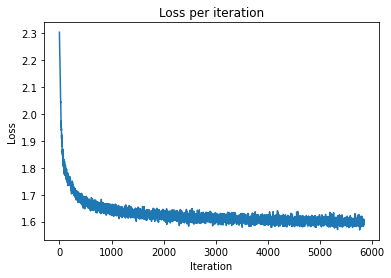

In [ ]:
plt.plot(np.arange(len(loss_history)), loss_history)
plt.title('Loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

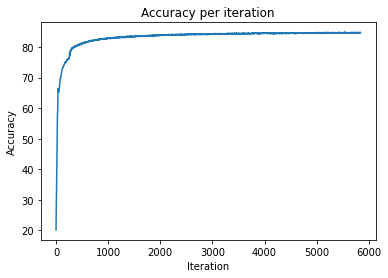

In [ ]:
plt.plot(np.arange(len(acc_history)), acc_history)
plt.title('Accuracy per iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

В каждой итерациии Adam смещает m и v наа сумму градиентов и сумму квадратов градиентов с заданными коэффициентами. После чего, веса сдвигаютсяя согаласно взвешенной оценке этих величин. В результате итеративного смещения в сторону уменьшения сдвига квадрата градиента, оценка квадрата градиента будет несмещенной. То есть, само получение оценки содержит поступательную коррекцию на квадрат градиента. 

Модель начала переобучаться примерно на 2500-3000-й итерации, поскольку к тому моменту доля правильных ответов практически вышла на горизонтальный тренд, а лосс стал снижатья значительно медленнее, а колебания его стали моментами возникать более значительные, чем прежде(это свидетельствует о. том, что модель стала сильно опдстраиваться под тренировочные данные). 

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [ ]:
from keras.datasets import cifar10

In [ ]:
# (trainX, trainy), (testX, testy) = cifar10.load_data()

In [222]:
NUM_EPOCH = 20 # нужно больше для лучшего качества. Но для образовательных целей хватит и 20, достаточно репрезентативно
batch_size_train = 64 #128 1024
batch_size_test = 128 #128 1024

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader( # your code here
                    fashion_mnist_train,
                    batch_size=batch_size_train, 
                    shuffle=True,
                    num_workers=1)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = test_loader = torch.utils.data.DataLoader( # your code here
                    fashion_mnist_eval,
                    batch_size=batch_size_test, 
                    shuffle=True,
                    num_workers=1)

device = 'cpu' # 'cuda'

In [223]:
# Полносвязная модель
first_model = nn.Sequential(
    # your code here
    nn.Flatten(),
    nn.Linear(784, 384),
    nn.ReLU(),
    nn.Linear(384, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)

first_model.to(device)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=384, bias=True)
  (2): ReLU()
  (3): Linear(in_features=384, out_features=128, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=128, out_features=10, bias=True)
  (6): Softmax(dim=-1)
)

In [253]:
# VGG
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        self.batch_norm = nn.BatchNorm2d(1)
        self.vgg = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.fc1 = nn.Linear(6272, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=-1)

        
    def forward(self, x):
        x = self.batch_norm(x)
        x = self.vgg(x)
        x = nn.Flatten()(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

second_model = SecondModel()

In [257]:
# ResNet-подобня архитектура
class ThirdModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.batch_norm = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Sequential(        # 7x7 kernel, 64 outs
         nn.Conv2d(1, 64, 7),
         nn.ReLU(),
         nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(        # 3x3 kernel, 64 outs
            nn.Conv2d(64, 64, 3),
            nn.ReLU())

        self.conv3 = nn.Sequential(        # 3x3 kernel, 128 outs
            nn.Conv2d(64, 128, 3),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(        # 3x3 kernel, 256 outs
            nn.Conv2d(128, 256, 3),
            nn.ReLU())
        
        
        self.fc1 = nn.Linear(6400, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
    
        x = nn.Flatten()(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(x)
        return x

third_model = ThirdModel()

In [204]:
# train and visualize and write summary down there

In [254]:
# Визуализировать
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [255]:
# тренировать модель 
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            # imgs, labels = imgs.to(device), labels.to(device)
            # imgs = imgs.view(-1, 28*28)
            # print(imgs.shape)
            
            y_pred = model(imgs)
            # print(y_pred)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # print(loss)
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))


        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('EPOCH: ' + str(epoch))
        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

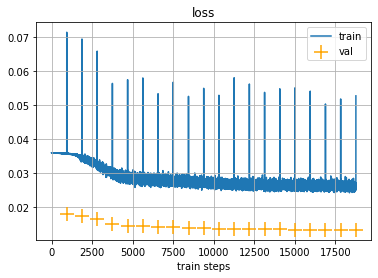

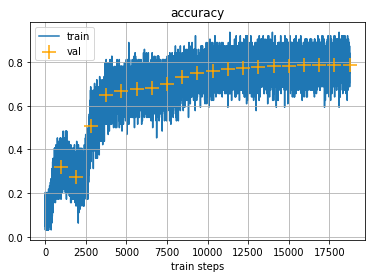

EPOCH: 19
Train loss: 0.02616502884229024
Train acc: 0.7980333333333334
Val loss: 0.013270565736293793
Val acc: 0.7893


In [207]:
# FIRST MODEL with SGD
first_model = nn.Sequential(
    # your code here
    nn.Flatten(),
    nn.Linear(784, 384),
    nn.ReLU(),
    nn.Linear(384, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)

first_model.to(device)

criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(first_model.parameters(), lr=0.001, momentum=0.9)

train(first_model, criterion1, optimizer1, train_dataloader, eval_dataloader)

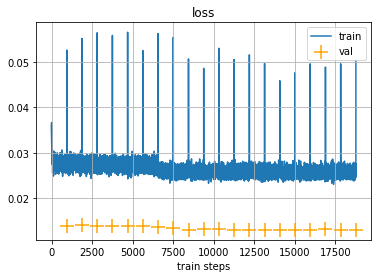

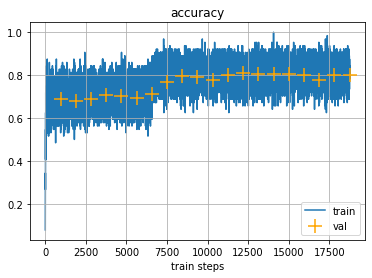

EPOCH: 19
Train loss: 0.025673267445961635
Train acc: 0.8187166666666666
Val loss: 0.013096970093250275
Val acc: 0.8012


In [230]:
# FIRST MODEL with RMSprop

first_model = nn.Sequential(
    # your code here
    nn.Flatten(),
    nn.Linear(784, 384),
    nn.ReLU(),
    nn.Linear(384, 128),
    nn.LeakyReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)

first_model.to(device)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.RMSprop(first_model.parameters(), lr=0.001)

train(first_model, criterion2, optimizer2, train_dataloader, eval_dataloader)

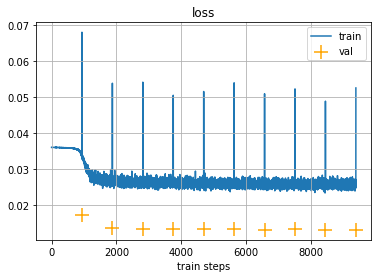

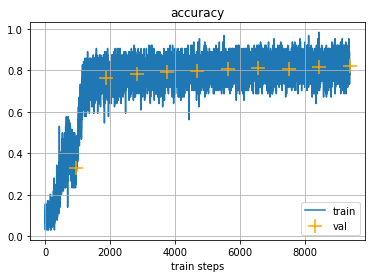

EPOCH: 9
Train loss: 0.025636806736389794
Train acc: 0.8234
Val loss: 0.012970441925525666
Val acc: 0.8204


KeyboardInterrupt: ignored

In [251]:
# SECOND MODEL with SGD
second_model3 = SecondModel()
second_model3.to(device)

criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(second_model3.parameters(), lr=0.001, momentum=0.9)

train(second_model3, criterion3, optimizer3, train_dataloader, eval_dataloader)

Сорри. Остановлю трейн на 10 эпохах. Слишком много времени и мощности затрачивается(да-да, время 02:45). Уже видно, что предсказание модели стабильно. 

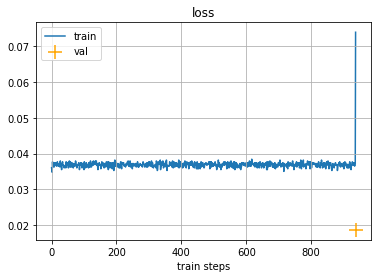

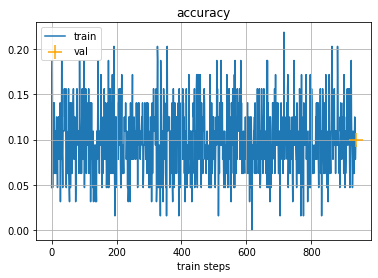

EPOCH: 0
Train loss: 0.03690824282169342
Train acc: 0.10011666666666667
Val loss: 0.01865637321472168
Val acc: 0.1


KeyboardInterrupt: ignored

In [256]:
# SECOND MODEL with RMSprop
second_model4 = SecondModel()
second_model4.to(device)

criterion4 = nn.CrossEntropyLoss()
optimizer4 = torch.optim.RMSprop(second_model4.parameters(), lr=0.001)

train(second_model4, criterion4, optimizer4, train_dataloader, eval_dataloader)

Не выгружу докона. Оцените архитектуру, пожалуйста. С ней все в порядке. 

Время 03:39. Убедился в том, чо они работают в черновом ноуте. Здесь ResNet-подобные сети не успеют прогрузиться полностью. Тем не менее, они работают, но accuracy на валидационных данных немного ниже, чем для VGG(~0.8). 

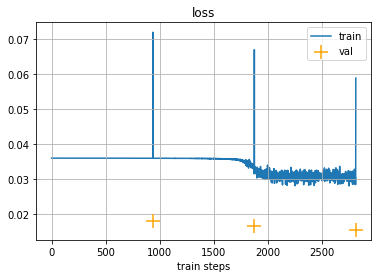

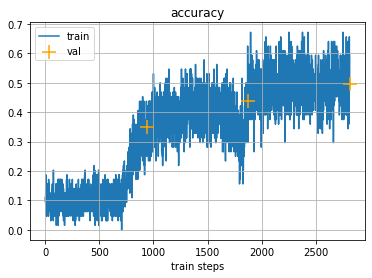

EPOCH: 2
Train loss: 0.03092130691607793
Train acc: 0.48941666666666667
Val loss: 0.01550117928981781
Val acc: 0.4965


KeyboardInterrupt: ignored

In [258]:
# THIRD MODEL with SGD
third_model5 = ThirdModel()
third_model5.to(device)

criterion5 = nn.CrossEntropyLoss()
optimizer5 = torch.optim.SGD(third_model5.parameters(), lr=0.001, momentum=0.9)

train(third_model5, criterion5, optimizer5, train_dataloader, eval_dataloader)

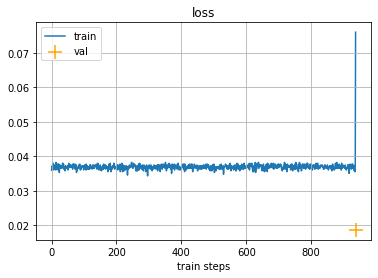

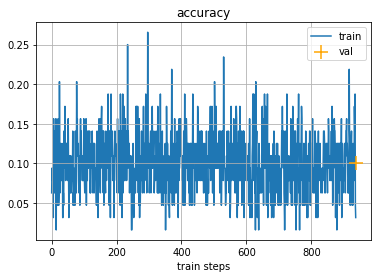

EPOCH: 0
Train loss: 0.03691319523652395
Train acc: 0.0999
Val loss: 0.01865090446472168
Val acc: 0.1


KeyboardInterrupt: ignored

In [261]:
# THIRD MODEL with RMSprop
third_model6 = ThirdModel()
third_model6.to(device)

criterion6 = nn.CrossEntropyLoss()
optimizer6 = torch.optim.RMSprop(third_model6.parameters(), lr=0.001)

train(third_model6, criterion6, optimizer6, train_dataloader, eval_dataloader)

Надеюсь, в том, что они не прогрузились полностью здесь(НО ОНИ УСПЕЛИ ПРОГРУЗИТЬСЯ В ЧЕРНОВОМ НОУТЕ. ОНИ ОТРАБАТЫВАЮТ) это не проблема, поскольку модель работает и показывает адекватные метрики на данных. 

## Вывод: 
Наилучшим образом себя проявила(на val_accuracy, в частности) VGG модель(в особенности, с SGD оптимизатором)(даже несмотря на то, что она недоучилась). Если правильно ее затюнить и увеличить вычислительные мощности и временной ресурс, можно выбить достаточно высокое качество(но и ~ 0.82 на валидационной выборке это очень неплохо, особенно для 10 эпох). 

Я 30 часов потратил на это домашнее задание на сессионной неделе. Благородный проверяющий, не убивай меня, пожалуйста. Терпения. 

<span style="color:red">Спасибо!</span> 

Ваш,
 
Давид

04:10. Sleep goes brrrrrrrr